<a href="https://colab.research.google.com/github/einjunge99/ETL/blob/migration/CreditFactory_v3_0_(Precalificaci%C3%B3n)_20_agosto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
`# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

SyntaxError: invalid syntax (<ipython-input-1-99a7dbf18236>, line 1)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GoogleCloudPlatform/cloud-sql-python-connector/blob/main/samples/notebooks/sqlserver_python_connector.ipynb)
# **Connect to Cloud SQL using the Cloud SQL Python Connector**


### 🔐 Authenticate to Google Cloud within Colab
Authenticate to Google Cloud as the IAM user logged into this notebook in order to access your Google Cloud Project.

In [ ]:
from google.colab import auth

auth.authenticate_user()

### 🔗 Connect Your Google Cloud Project
Time to connect your Google Cloud Project to this notebook so that you can leverage Google Cloud from within Colab. 🏅 😀

In [ ]:
#@markdown Please fill in the value below with your GCP project ID and then run the cell.

# Please fill in these values.
project_id = "uvg-integrador" #@param {type:"string"}

# Quick input validations.
assert project_id, "⚠️ Please provide a Google Cloud project ID"

# Configure gcloud.
!gcloud config set project {project_id}

Updated property [core/project].


### ☁ Configure Your Google Cloud Project
Configure the following in your Google Cloud Project.

1. IAM principal (user, service account, etc.) with the
[Cloud SQL Client][client-role] role.

> 🚨 The user logged into this notebook will be used as the IAM principal and will be granted the Cloud SQL Client role.

[client-role]: https://cloud.google.com/sql/docs/mysql/roles-and-permissions

In [ ]:
# grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

!gcloud projects add-iam-policy-binding {project_id} \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"

Updated IAM policy for project [uvg-integrador].
bindings:
- members:
  - user:2982192200101@ingenieria.usac.edu.gt
  - user:nelsonalesandrog@gmail.com
  role: roles/cloudsql.client
- members:
  - serviceAccount:service-108581707894@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:108581707894-compute@developer.gserviceaccount.com
  - serviceAccount:108581707894@cloudservices.gserviceaccount.com
  role: roles/editor
- members:
  - user:2982192200101@ingenieria.usac.edu.gt
  - user:mor231807@uvg.edu.gt
  - user:nelsonalesandrog@gmail.com
  role: roles/owner
etag: BwYgJ3PPpDI=
version: 1


2. Enable the [Cloud SQL Admin API][admin-api] within your project.

[admin-api]: https://console.cloud.google.com/apis/api/sqladmin.googleapis.com

In [ ]:
# enable Cloud SQL Admin API
!gcloud services enable sqladmin.googleapis.com

## 🐍 Python Connector Usage
Let's now connect to Cloud SQL using the Python Connector! 🚀 ⭐ 🐍

### 💻 **Install Code Dependencies**
It is recommended to use the Connector alongside a library that can create connection pools, such as [SQLAlchemy](https://www.sqlalchemy.org/).
This will allow for connections to remain open and be reused, reducing connection overhead and the number of connections needed

Let's `pip install` the [Cloud SQL Python Connector](https://github.com/GoogleCloudPlatform/cloud-sql-python-connector) as well as [SQLAlchemy](https://www.sqlalchemy.org/), using the below command.

In [ ]:
# install dependencies
import sys
!{sys.executable} -m pip install cloud-sql-python-connector["pytds"] SQLAlchemy==2.0.7 sqlalchemy-pytds==0.3.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.7 MB/s eta 0:00:00
  Created wheel for python-tds: filename=python_tds-1.15.0-py3-none-any.whl size=85032 sha256=6dee77c8ab5f6fd3fb284e8cd3046e833cb1c60fd056d8f136a0b5a23292ddb1
  Stored in directory: /root/.cache/pip/wheels/fb/18/28/9255c9a9f47d6fc0ccc229eef066356b9d0a6b07aec4f50114
Successfully built python-tds
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.32
    Uninstalling SQLAlchemy-2.0.32:
      Successfully uninstalled SQLAlchemy-2.0.32
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.27.0
    Uninstalling google-auth-2.27.0:
      Successfully uninstalled google-auth-2.27.0
E

## 🗄 **Connect to a SQL Server Instance**
We are now ready to connect to a SQL Server instance using the Cloud SQL Python Connector! 🐍 ⭐ ☁


Let's set some parameters that are needed to connect properly to a Cloud SQL instance:
*   `INSTANCE_CONNECTION_NAME` : The connection name to your Cloud SQL Instance, takes the form `PROJECT_ID:REGION:INSTANCE_NAME`.
*   `DB_USER` : The user that the connector will use to connect to the database.
*   `DB_PASS` : The password of the DB_USER.
*   `DB_NAME` : The name of the database on the Cloud SQL instance to connect to.

In [ ]:
region = "us-central1" #@param {type:"string"}
instance_name = "s7crdt" #@param {type:"string"}

# initialize parameters
INSTANCE_CONNECTION_NAME = f"{project_id}:{region}:{instance_name}" # i.e demo-project:us-central1:demo-instance
print(f"Your instance connection name is: {INSTANCE_CONNECTION_NAME}")
DB_USER = "sqlserver"
DB_PASS = "MaquinaUVG."
DB_NAME = "s7credit"

Your instance connection name is: uvg-integrador:us-central1:s7crdt


### ✅ **Basic Usage**
To connect to Cloud SQL using the connector, inititalize a `Connector` object and call its `connect` method with the proper input parameters.

The `connect` method takes in the parameters we previously defined, as well as a few additional parameters such as:
*   `driver`: The name of the database driver to connect with.
*   `ip_type` (optional): The IP type (public or private)  used to connect. IP types can be either `IPTypes.PUBLIC` or `IPTypes.PRIVATE`. ([Example](#scrollTo=yjAPpIDdRfu2))
*   `enable_iam_auth`: (optional) Boolean enabling IAM based authentication. (Postgres and MySQL only)

Let's show an example! 🤘 🙌

In [ ]:
from google.cloud.sql.connector import Connector, IPTypes
import sqlalchemy
from sqlalchemy import Column, Float, Integer, String, Table

# initialize Connector object
connector = Connector()

# function to return the database connection object
def getconn():
    conn = connector.connect(
        INSTANCE_CONNECTION_NAME,
        "pytds",
        user=DB_USER,
        password=DB_PASS,
        db=DB_NAME,
    )
    return conn

# create connection pool with 'creator' argument to our connection object function
pool = sqlalchemy.create_engine(
    "mssql+pytds://",
    creator=getconn,
    connect_args={"charset": "utf-8"}
)

<ipython-input-9-6798d6ff0d28>:20: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'sqlalchemy_pytds.dialect.MSDialect_pytds'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  pool = sqlalchemy.create_engine(


To use this connector with SQLAlchemy, we use the `creator` argument for `sqlalchemy.create_engine`

Now that we have established a connection pool, let's write a query! 🎉 📝

In [ ]:
import pandas as pd
from sqlalchemy import text

# ETL

## Text Analytics

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_accion_etapa = pd.read_sql('select acc.Descripcion from dbo.S7N_WF_ETAPA_INCIDENTE_HISTORIAL_TIEMPO_EVENTO hist, dbo.WF_Accion_etapa  acc where acc.Etapa_incidente  = hist.IdEtapaIncidente  and hist.IdTipoEvento = 7', db_conn)
    #raw_wf_accion_etapa = pd.read_sql(text("select * from dbo.WF_Accion_etapa"), db_conn)

InterfaceError: (pytds.tds_base.InterfaceError) Invalid TDS marker: 0(0)
(Background on this error at: https://sqlalche.me/e/20/rvf5)

## Dimensionales

In [ ]:
gold_dimensional = pd.DataFrame({
    'id_dimensional': [1, 2, 3],
    'nombre': ['Minutos',  'Horas', 'Días'],
    'valor': [1, 60, 1440]
}
)

## Empleado

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_tc_epl_empleado = pd.read_sql(text("select * from dbo.TC_EPL_EMPLEADO"), db_conn)

In [ ]:
raw_tc_epl_empleado.head()

,EMPLEADO,EXTENSION,ACTIVO,PUE_PUESTO,EXPERIENCIA_CC,AAT_ATENCION,COMENTARIO,SUELDO,TIPO_SALARIO,TUR_TURNO,Empresa,email,GrupoTrabajo,NoAplicaCarga,Perfil
0,0,None,A,0,False,0,None,6.0,None,0,1,empleado_0_correo@sigma7uat.com,NaN,None,0
1,1,None,A,0,False,20017,PM/QA,6000.0,M,1,1,empleado_1_correo@sigma7uat.com,NaN,None,0
2,2,,A,0,False,0,None,0.0,None,0,1,empleado_2_correo@sigma7uat.com,NaN,None,0
3,9,,A,0,False,0,None,0.0,None,0,1,empleado_9_correo@sigma7uat.com,NaN,None,0
4,24,None,A,0,False,20017,None,0.0,H,0,1,empleado_24_correo@sigma7uat.com,NaN,None,0


In [ ]:
tc_epl_empleado = raw_tc_epl_empleado[
    [
     'EMPLEADO',
     'email',
     'GrupoTrabajo'
     ]
    ].rename(columns={
    'EMPLEADO': 'id_empleado',
    'email': 'email',
})


## Tiempo Evento

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_tipo_evento = pd.read_sql(text("SELECT * FROM dbo.S7N_WF_TIPO_EVENTO_TIEMPO"), db_conn)

# Show the DataFrame
print(raw_wf_tipo_evento)

   Id        Nombre
0   1      CREACIÓN
1   2   CANCELACIÓN
2   3  FINALIZACIÓN
3   4        INICIO
4   5    ASIGNACIÓN
5   6     REPROCESO
6   7       RECHAZO
7   8  REACTIVACIÓN
8   9      ATENCIÓN


In [ ]:
silver_wf_tipo_evento = raw_wf_tipo_evento[[
    'Id',
    'Nombre',
    ]].rename(
    columns={
        'Id': 'id_tipo_evento',
        'Nombre': 'nombre',
    }
)

In [ ]:
gold_wf_tipo_evento = silver_wf_tipo_evento.copy(deep = True)

## Etapa Incidente Historial Tiempo Evento




In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_etapa_incidente_historial_tiempo_evento = pd.read_sql(text("SELECT * FROM dbo.S7N_WF_ETAPA_INCIDENTE_HISTORIAL_TIEMPO_EVENTO"), db_conn)

# Show the DataFrame
print(raw_wf_etapa_incidente_historial_tiempo_evento)

              Id           FechaRegistro      FechaActualizacion  Tiempo  \
0              1 2019-09-03 11:24:15.493 2019-09-03 11:28:00.867       4   
1              2 2019-09-03 11:28:00.867 2019-09-03 11:28:00.900       0   
2              3 2019-09-03 11:28:00.900 2019-09-03 11:28:00.930       0   
3              4 2019-09-03 11:28:00.930 2019-09-03 11:40:51.010      12   
4              5 2019-09-03 11:40:51.010 2019-09-03 11:40:51.023       0   
...          ...                     ...                     ...     ...   
2074834  2119552 2024-05-31 15:31:43.293 2024-05-31 15:47:00.927      16   
2074835  2119553 2024-05-31 15:47:00.927 2024-05-31 15:47:00.960       0   
2074836  2119554 2024-05-31 15:47:00.960 2024-05-31 15:47:17.223       0   
2074837  2119555 2024-05-31 15:47:17.223 2024-05-31 15:47:17.243       0   
2074838  2119556 2024-05-31 15:47:17.243                     NaT       0   

         TiempoCorrido  EstadoAnterior  EstadoActual  IdEtapaIncidente  \
0            

In [ ]:
raw_wf_etapa_incidente_historial_tiempo_evento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2074839 entries, 0 to 2074838
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Id                  int64         
 1   FechaRegistro       datetime64[ns]
 2   FechaActualizacion  datetime64[ns]
 3   Tiempo              int64         
 4   TiempoCorrido       int64         
 5   EstadoAnterior      float64       
 6   EstadoActual        int64         
 7   IdEtapaIncidente    int64         
 8   IdTipoEvento        int64         
 9   IdEmpleadoOpera     float64       
 10  IdEmpleadoAsignado  float64       
dtypes: datetime64[ns](2), float64(3), int64(6)
memory usage: 174.1 MB


In [ ]:
silver_wf_etapa_incidente_historial_tiempo_evento = raw_wf_etapa_incidente_historial_tiempo_evento[[
    'Id',
    'FechaRegistro',
    'FechaActualizacion',
    'Tiempo',
    'IdEtapaIncidente',
    'IdTipoEvento',
    'IdEmpleadoOpera',
    'IdEmpleadoAsignado',
    ]].rename(
    columns={
        'Id': 'id_etapa_incidente_historial_tiempo_evento',
        'FechaRegistro': 'fecha_registro',
        'FechaActualizacion': 'fecha_actualizacion',
        'Tiempo': 'tiempo',
        'IdEtapaIncidente': 'id_etapa_incidente',
        'IdTipoEvento': 'id_tipo_evento',
        'IdEmpleadoOpera': 'id_empleado_opera',
        'IdEmpleadoAsignado': 'id_empleado_asignado'
        }
)

In [ ]:
silver_wf_etapa_incidente_historial_tiempo_evento['id_empleado_opera'] = silver_wf_etapa_incidente_historial_tiempo_evento['id_empleado_opera'].astype('Int64')
silver_wf_etapa_incidente_historial_tiempo_evento['id_empleado_asignado'] = silver_wf_etapa_incidente_historial_tiempo_evento['id_empleado_asignado'].astype('Int64')

In [ ]:
gold_wf_etapa_incidente_historial_tiempo_evento = silver_wf_etapa_incidente_historial_tiempo_evento.copy(deep = True)

## Proceso

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_proceso = pd.read_sql(text("SELECT * FROM dbo.WF_Proceso"), db_conn)

In [ ]:
print(raw_wf_proceso.isnull().sum())
print(raw_wf_proceso.info())

Proceso                       0
Nombre                        0
Tiempo_estimado               0
Muestra_QA                    0
Clase_proceso                 0
Unidad_medida                 0
Max_frecuencia_diaria         0
Dia_antes_alarma              0
Empleado_creacion             0
Fecha_creacion                0
Empleado_modifica             0
Fecha_modifica                0
Tipo_proceso                  0
Estado                        0
Porcentaje_holgura            0
Descripcion                   0
Empleado_encargado            5
asignacion_etapa_inicial      1
Tipo_Fin_Etapa_Inicial        3
Empresa_Retipifica            5
Unidad_Negocio_Retipifica     5
Self_Service                  0
Origen                        5
Gestion_Externa               0
Cantidad_Incidentes           0
Requiere_Meta                 0
EnvioMail                     0
NotificacionQueja             3
NotificacionCierre            0
NotificacionApertura          0
IncluyeReporteSI              5
Tipologi

In [ ]:
silver_wf_proceso = raw_wf_proceso[[
    'Proceso', 'Nombre'
]].rename(columns={
    'Proceso': 'id_proceso',
    'Nombre': 'nombre_proceso',
})

In [ ]:
gold_wf_proceso = silver_wf_proceso.copy(deep=True)

## Etapa

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_etapa = pd.read_sql(text("SELECT * FROM dbo.WF_Etapa"), db_conn)

In [ ]:
silver_wf_etapa = raw_wf_etapa[[
    'Etapa', 'Proceso', 'Nombre', 'Tiempo_estimado', 'Unidad_medida'
]].rename(columns={
    'Etapa': 'id_etapa',
    'Proceso': 'id_proceso',
    'Nombre': 'nombre_etapa',
    'Tiempo_estimado': 'tiempo_estimado_etapa',
    'Unidad_medida': 'unidad_medida_etapa'
})


In [ ]:
gold_wf_etapa = silver_wf_etapa.copy(deep=True)

In [ ]:
gold_wf_etapa.head()

,id_etapa,id_proceso,nombre_etapa,tiempo_estimado_etapa,unidad_medida_etapa
0,1,1,Solicitud ...,2.0,2
1,2,1,Aprobacion ...,2.0,1
2,3,1,Aprobacion I ...,2.0,1
3,4,1,Aprobación II ...,2.0,1
4,5,1,Aprobación III ...,2.0,1


## Incidente

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_incidente = pd.read_sql(text("SELECT * FROM dbo.WF_Incidente"), db_conn)

# Show the DataFrame
print(raw_wf_incidente)

       Incidente      Fecha_hora_entrada  Persona  Cliente  Tipo_cliente  \
0              1 2019-09-03 11:24:15.087    19079    19026             2   
1              2 2019-09-03 16:29:25.830    20460    20283             3   
2              3 2019-09-03 17:08:53.837    18488    18446             2   
3              4 2019-09-04 12:32:44.307    20466    20289             3   
4              5 2019-09-04 12:47:23.687    20470    20293             3   
...          ...                     ...      ...      ...           ...   
36293      37343 2023-12-19 16:10:12.087   100138    99943             2   
36294      37344 2023-12-19 16:36:52.713   108972   108777             2   
36295      37345 2023-12-19 16:40:30.323   108947   108752             2   
36296      37346 2023-12-19 16:59:31.110   108892   108697             2   
36297      37347 2023-12-19 17:09:53.103    99055    98860             2   

      Empleado_asigna  Estado            Fecha_estado  Proceso  Empleado_crea  \
0     

### Análisis exploratorio

In [ ]:
# General overview of the DataFrame
print(raw_wf_incidente.info())

# Display the first few rows of the DataFrame
print(raw_wf_incidente.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36298 entries, 0 to 36297
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Incidente            36298 non-null  int64         
 1   Fecha_hora_entrada   36298 non-null  datetime64[ns]
 2   Persona              36298 non-null  int64         
 3   Cliente              36298 non-null  int64         
 4   Tipo_cliente         36298 non-null  int64         
 5   Empleado_asigna      0 non-null      object        
 6   Estado               36298 non-null  int64         
 7   Fecha_estado         36298 non-null  datetime64[ns]
 8   Proceso              36298 non-null  int64         
 9   Empleado_crea        36298 non-null  int64         
 10  Incidente_anterior   2 non-null      float64       
 11  Area_atencion        36298 non-null  int64         
 12  Empresa_crea         36298 non-null  int64         
 13  Descripcion          36298 non-

In [ ]:
# Summary statistics of numerical columns
print(raw_wf_incidente.describe())

# Summary statistics of non-numerical columns
print(raw_wf_incidente.describe(include=['object']))


          Incidente             Fecha_hora_entrada        Persona  \
count  36298.000000                          36298   36298.000000   
mean   18710.737809  2022-03-31 23:48:35.299861760   55984.922337   
min        1.000000     2019-09-03 11:24:15.087000   10360.000000   
25%     9097.250000  2021-06-18 14:32:37.454999808   34447.500000   
50%    19180.500000  2022-05-29 07:43:55.312999936   54285.500000   
75%    28262.750000  2023-04-05 15:54:30.776999936   75260.250000   
max    37347.000000     2023-12-19 17:09:53.103000  108972.000000   
std    10924.407649                            NaN   25595.810229   

             Cliente  Tipo_cliente        Estado  \
count   36298.000000  36298.000000  36298.000000   
mean    55802.531847      2.118078      2.301559   
min     10340.000000      2.000000      1.000000   
25%     34251.500000      2.000000      2.000000   
50%     54090.500000      2.000000      2.000000   
75%     75065.250000      2.000000      3.000000   
max    108777.

In [ ]:
# Check for missing values
print(raw_wf_incidente.isnull().sum())

NameError: name 'wf_incidente' is not defined

array([[<Axes: title={'center': 'Incidente'}>,
        <Axes: title={'center': 'Fecha_hora_entrada'}>,
        <Axes: title={'center': 'Persona'}>,
        <Axes: title={'center': 'Cliente'}>],
       [<Axes: title={'center': 'Tipo_cliente'}>,
        <Axes: title={'center': 'Estado'}>,
        <Axes: title={'center': 'Fecha_estado'}>,
        <Axes: title={'center': 'Proceso'}>],
       [<Axes: title={'center': 'Empleado_crea'}>,
        <Axes: title={'center': 'Incidente_anterior'}>,
        <Axes: title={'center': 'Area_atencion'}>,
        <Axes: title={'center': 'Empresa_crea'}>],
       [<Axes: title={'center': 'GrupoTrabajoEpl'}>,
        <Axes: title={'center': 'Gestion_Externa'}>,
        <Axes: title={'center': 'Prioridad'}>, <Axes: >]], dtype=object)

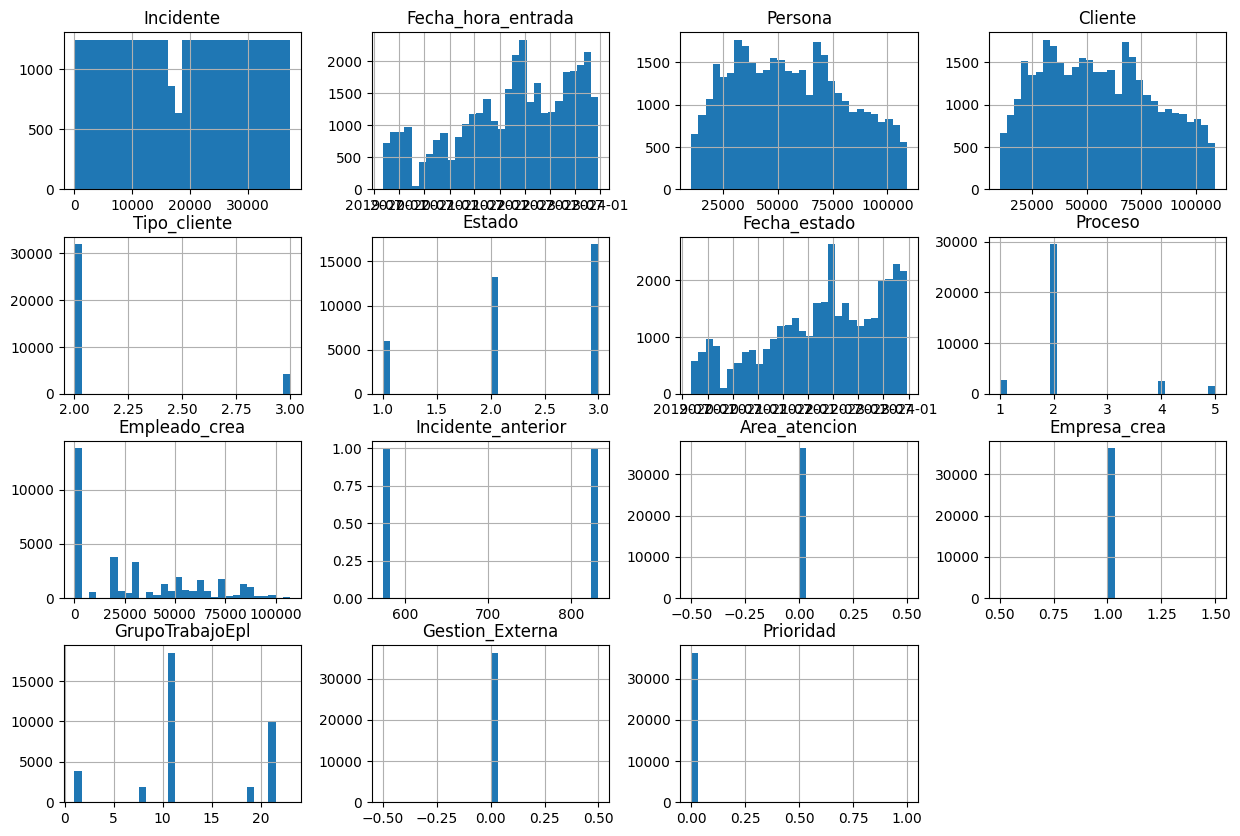

In [ ]:
# Plotting histograms for all numerical columns
raw_wf_incidente.hist(bins=30, figsize=(15, 10))


### Limpieza

In [ ]:
silver_wf_incidente = raw_wf_incidente[[
    'Incidente',
    'Fecha_hora_entrada',
    'Persona',
    'Cliente',
    'Estado',
    'Proceso',
    'Empleado_crea',
    'Descripcion',
    ]].rename(
    columns={
        'Incidente': 'id_incidente',
        'Fecha_hora_entrada': 'fecha_creacion',
        'Persona': 'id_persona',
        'Cliente': 'id_cliente',
        'Estado': 'estado',
        'Proceso': 'id_proceso',
        'Empleado_crea': 'id_empleado_crea',
        'Descripcion': 'descripcion'
        }
)

In [ ]:
estado_mapping = {1: 'En proceso', 2: 'Cancelado', 3: 'Finalizado'}

In [ ]:
silver_wf_incidente['estado'] = silver_wf_incidente['estado'].map(estado_mapping).fillna('Desconocido')

In [ ]:
silver_wf_incidente

,id_incidente,fecha_creacion,id_persona,id_cliente,estado,id_proceso,id_empleado_crea,descripcion
0,1,2019-09-03 11:24:15.087,19079,19026,Cancelado,2,0,Incidente creado desde el cotizador asociado a...
1,2,2019-09-03 16:29:25.830,20460,20283,Finalizado,1,2,Incidente creado desde el cotizador asociado a...
2,3,2019-09-03 17:08:53.837,18488,18446,Cancelado,4,2,Incidente creado desde el cotizador asociado a...
3,4,2019-09-04 12:32:44.307,20466,20289,Finalizado,2,29,Incidente creado desde el cotizador asociado a...
4,5,2019-09-04 12:47:23.687,20470,20293,Finalizado,2,29,Incidente creado desde el cotizador asociado a...
...,...,...,...,...,...,...,...,...
36293,37343,2023-12-19 16:10:12.087,100138,99943,En proceso,2,63662,Incidente creado desde el cotizador asociado a...
36294,37344,2023-12-19 16:36:52.713,108972,108777,En proceso,1,30429,Incidente creado desde el cotizador asociado a...
36295,37345,2023-12-19 16:40:30.323,108947,108752,En proceso,2,71752,Incidente creado desde el cotizador asociado a...
36296,37346,2023-12-19 16:59:31.110,108892,108697,En proceso,2,85,Incidente creado desde el cotizador asociado a...


In [ ]:
print(silver_wf_incidente.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36298 entries, 0 to 36297
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_incidente      36298 non-null  int64         
 1   fecha_creacion    36298 non-null  datetime64[ns]
 2   id_persona        36298 non-null  int64         
 3   id_cliente        36298 non-null  int64         
 4   estado            36298 non-null  object        
 5   id_proceso        36298 non-null  int64         
 6   id_empleado_crea  36298 non-null  int64         
 7   descripcion       36298 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.2+ MB
None


In [ ]:
# Realizar el merge entre los dos DataFrames
gold_wf_incidente =  silver_wf_incidente.copy(deep=True)

In [ ]:
print(gold_wf_incidente.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36298 entries, 0 to 36297
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_incidente      36298 non-null  int64         
 1   fecha_creacion    36298 non-null  datetime64[ns]
 2   id_persona        36298 non-null  int64         
 3   id_cliente        36298 non-null  int64         
 4   estado            36298 non-null  object        
 5   id_proceso        36298 non-null  int64         
 6   id_empleado_crea  36298 non-null  int64         
 7   descripcion       36298 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.2+ MB
None


## Tiempos

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_etapa_incidente_historial_tiempo_evento = pd.read_sql(text("SELECT * FROM dbo.S7N_WF_ETAPA_INCIDENTE_HISTORIAL_TIEMPO_EVENTO"), db_conn)

# Show the DataFrame
print(raw_wf_etapa_incidente_historial_tiempo_evento)

              Id           FechaRegistro      FechaActualizacion  Tiempo  \
0              1 2019-09-03 11:24:15.493 2019-09-03 11:28:00.867       4   
1              2 2019-09-03 11:28:00.867 2019-09-03 11:28:00.900       0   
2              3 2019-09-03 11:28:00.900 2019-09-03 11:28:00.930       0   
3              4 2019-09-03 11:28:00.930 2019-09-03 11:40:51.010      12   
4              5 2019-09-03 11:40:51.010 2019-09-03 11:40:51.023       0   
...          ...                     ...                     ...     ...   
2074834  2119552 2024-05-31 15:31:43.293 2024-05-31 15:47:00.927      16   
2074835  2119553 2024-05-31 15:47:00.927 2024-05-31 15:47:00.960       0   
2074836  2119554 2024-05-31 15:47:00.960 2024-05-31 15:47:17.223       0   
2074837  2119555 2024-05-31 15:47:17.223 2024-05-31 15:47:17.243       0   
2074838  2119556 2024-05-31 15:47:17.243                     NaT       0   

         TiempoCorrido  EstadoAnterior  EstadoActual  IdEtapaIncidente  \
0            

In [ ]:
wf_etapa_incidente_historial_tiempo_evento = raw_wf_etapa_incidente_historial_tiempo_evento.copy(deep=True)

In [ ]:
wf_etapa_incidente_historial_tiempo_evento.head()

,Id,FechaRegistro,FechaActualizacion,Tiempo,TiempoCorrido,EstadoAnterior,EstadoActual,IdEtapaIncidente,IdTipoEvento,IdEmpleadoOpera,IdEmpleadoAsignado
0,1,2019-09-03 11:24:15.493,2019-09-03 11:28:00.867,4,4,1.0,1,1,1,2.0,NaN
1,2,2019-09-03 11:28:00.867,2019-09-03 11:28:00.900,0,0,1.0,1,1,9,2.0,2.0
2,3,2019-09-03 11:28:00.900,2019-09-03 11:28:00.930,0,0,1.0,1,1,5,2.0,2.0
3,4,2019-09-03 11:28:00.930,2019-09-03 11:40:51.010,12,12,1.0,1,1,4,2.0,2.0
4,5,2019-09-03 11:40:51.010,2019-09-03 11:40:51.023,0,0,1.0,1,1,9,2.0,2.0


In [ ]:
import pandas as pd
from datetime import datetime

In [ ]:
wf_etapa_incidente_historial_tiempo_evento['FechaRegistro'] = pd.to_datetime(
    wf_etapa_incidente_historial_tiempo_evento['FechaRegistro'],
    format='%Y-%m-%d %H:%M:%S.%f'
)

# Ensure FechaActualizacion is a datetime object or NaT
wf_etapa_incidente_historial_tiempo_evento['FechaActualizacion'] = pd.to_datetime(
    wf_etapa_incidente_historial_tiempo_evento['FechaActualizacion'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'  # Convert non-parsable dates to NaT
)

# Remove rows where FechaActualizacion is NaT (null)
wf_etapa_incidente_historial_tiempo_evento_cleaned = wf_etapa_incidente_historial_tiempo_evento.dropna(subset=['FechaActualizacion'])

# Display the filtered DataFrame
print(wf_etapa_incidente_historial_tiempo_evento)

              Id           FechaRegistro      FechaActualizacion  Tiempo  \
0              1 2019-09-03 11:24:15.493 2019-09-03 11:28:00.867       4   
1              2 2019-09-03 11:28:00.867 2019-09-03 11:28:00.900       0   
2              3 2019-09-03 11:28:00.900 2019-09-03 11:28:00.930       0   
3              4 2019-09-03 11:28:00.930 2019-09-03 11:40:51.010      12   
4              5 2019-09-03 11:40:51.010 2019-09-03 11:40:51.023       0   
...          ...                     ...                     ...     ...   
2074834  2119552 2024-05-31 15:31:43.293 2024-05-31 15:47:00.927      16   
2074835  2119553 2024-05-31 15:47:00.927 2024-05-31 15:47:00.960       0   
2074836  2119554 2024-05-31 15:47:00.960 2024-05-31 15:47:17.223       0   
2074837  2119555 2024-05-31 15:47:17.223 2024-05-31 15:47:17.243       0   
2074838  2119556 2024-05-31 15:47:17.243                     NaT       0   

         TiempoCorrido  EstadoAnterior  EstadoActual  IdEtapaIncidente  \
0            

In [ ]:
# Convert FechaRegistro to datetime with precision for milliseconds
wf_etapa_incidente_historial_tiempo_evento['FechaRegistro'] = pd.to_datetime(
    wf_etapa_incidente_historial_tiempo_evento['FechaRegistro'], format='%Y-%m-%d %H:%M:%S.%f'
)

specific_datetime = datetime.strptime('2024-05-31 15:47:17.243', '%Y-%m-%d %H:%M:%S.%f')

# Apply the script only to rows where FechaActualizacion is null (NaN)
mask = wf_etapa_incidente_historial_tiempo_evento['FechaActualizacion'].isna()

# Calculate the difference in minutes between the current date and FechaRegistro for those records
wf_etapa_incidente_historial_tiempo_evento.loc[mask, 'Tiempo'] = (
    specific_datetime - wf_etapa_incidente_historial_tiempo_evento.loc[mask, 'FechaRegistro']
).dt.total_seconds() / 60

wf_etapa_incidente_historial_tiempo_evento['Tiempo'] = wf_etapa_incidente_historial_tiempo_evento['Tiempo'].map('{:.2f}'.format)

# Display the dataframe with the new column
print(wf_etapa_incidente_historial_tiempo_evento)

              Id           FechaRegistro      FechaActualizacion Tiempo  \
0              1 2019-09-03 11:24:15.493 2019-09-03 11:28:00.867   4.00   
1              2 2019-09-03 11:28:00.867 2019-09-03 11:28:00.900   0.00   
2              3 2019-09-03 11:28:00.900 2019-09-03 11:28:00.930   0.00   
3              4 2019-09-03 11:28:00.930 2019-09-03 11:40:51.010  12.00   
4              5 2019-09-03 11:40:51.010 2019-09-03 11:40:51.023   0.00   
...          ...                     ...                     ...    ...   
2074834  2119552 2024-05-31 15:31:43.293 2024-05-31 15:47:00.927  16.00   
2074835  2119553 2024-05-31 15:47:00.927 2024-05-31 15:47:00.960   0.00   
2074836  2119554 2024-05-31 15:47:00.960 2024-05-31 15:47:17.223   0.00   
2074837  2119555 2024-05-31 15:47:17.223 2024-05-31 15:47:17.243   0.00   
2074838  2119556 2024-05-31 15:47:17.243                     NaT   0.00   

         TiempoCorrido  EstadoAnterior  EstadoActual  IdEtapaIncidente  \
0                    4   

To close the `Connector` object's background resources, call it's `close() ` method at the end of your code as follows:


In [ ]:
tiempo_por_etapa_incidente = wf_etapa_incidente_historial_tiempo_evento.groupby('IdEtapaIncidente')['Tiempo'].sum().reset_index()
print(tiempo_por_etapa_incidente)

        IdEtapaIncidente  Tiempo
0                      1     272
1                      2       3
2                      3       2
3                      4       1
4                      5  545013
...                  ...     ...
326572            328973       0
326573            328974       0
326574            328975       0
326575            328976       1
326576            328977       0

[326577 rows x 2 columns]


In [ ]:
silver_tiempos = tiempo_por_etapa_incidente[[
    'IdEtapaIncidente', 'Tiempo'
]].rename(columns={
    'IdEtapaIncidente': 'id_etapa_incidente',
    'Tiempo': 'tiempo',
})

In [ ]:
gold_tiempos = silver_tiempos.copy(deep=True)

## Etapa Incidente

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_etapa_incidente = pd.read_sql(text("SELECT * FROM dbo.WF_Etapa_incidente"), db_conn)

In [ ]:
raw_wf_etapa_incidente.head()

,Etapa_incidente,Incidente,Etapa,Fecha_hora_entrada,Estado,Empleado_asignado,Fecha_asignacion,Fecha_estado,Empleado_asigna,Estado_asignacion,Estado_aceptacion,Prioridad,fecha_sugerida_atencion,num_rechazos,estado_anterior_cancelacion,GrupoTrabajoEpl,fecha_iniciogestion,reproceso,estado_anterior,EnAtencion
0,1,1,25,2019-09-03 11:24:15.383,2,2.0,2019-09-03 11:28:00.867,2021-03-06 18:05:22.503,2.0,2,2,0,2019-09-03 11:24:15.383,0,3.0,11.0,None,0,0,False
1,2,1,27,2019-09-03 15:56:58.433,2,2.0,2019-09-03 15:58:37.560,2021-03-06 18:05:22.503,2.0,2,2,0,2019-09-03 15:55:00.000,0,3.0,12.0,None,0,0,False
2,3,1,28,2019-09-03 15:59:49.700,2,2.0,2019-09-03 16:00:32.480,2021-03-06 18:05:22.503,2.0,2,2,0,2019-09-03 15:58:00.000,0,3.0,13.0,None,0,0,False
3,4,1,34,2019-09-03 16:01:59.293,2,2.0,2019-09-03 16:01:59.293,2021-03-06 18:05:22.503,NaN,1,2,0,2019-09-03 16:00:00.000,0,3.0,11.0,None,0,0,False
4,5,1,52,2019-09-03 16:02:31.873,2,2.0,2019-09-03 16:05:14.967,2021-03-06 18:05:22.503,2.0,2,2,0,2019-09-03 16:02:00.000,0,1.0,3.0,None,0,0,False


array([[<Axes: title={'center': 'Etapa_incidente'}>,
        <Axes: title={'center': 'Incidente'}>,
        <Axes: title={'center': 'Etapa'}>,
        <Axes: title={'center': 'Fecha_hora_entrada'}>],
       [<Axes: title={'center': 'Estado'}>,
        <Axes: title={'center': 'Empleado_asignado'}>,
        <Axes: title={'center': 'Fecha_asignacion'}>,
        <Axes: title={'center': 'Fecha_estado'}>],
       [<Axes: title={'center': 'Empleado_asigna'}>,
        <Axes: title={'center': 'Estado_asignacion'}>,
        <Axes: title={'center': 'Estado_aceptacion'}>,
        <Axes: title={'center': 'Prioridad'}>],
       [<Axes: title={'center': 'fecha_sugerida_atencion'}>,
        <Axes: title={'center': 'num_rechazos'}>,
        <Axes: title={'center': 'estado_anterior_cancelacion'}>,
        <Axes: title={'center': 'GrupoTrabajoEpl'}>],
       [<Axes: title={'center': 'reproceso'}>,
        <Axes: title={'center': 'estado_anterior'}>, <Axes: >, <Axes: >]],
      dtype=object)

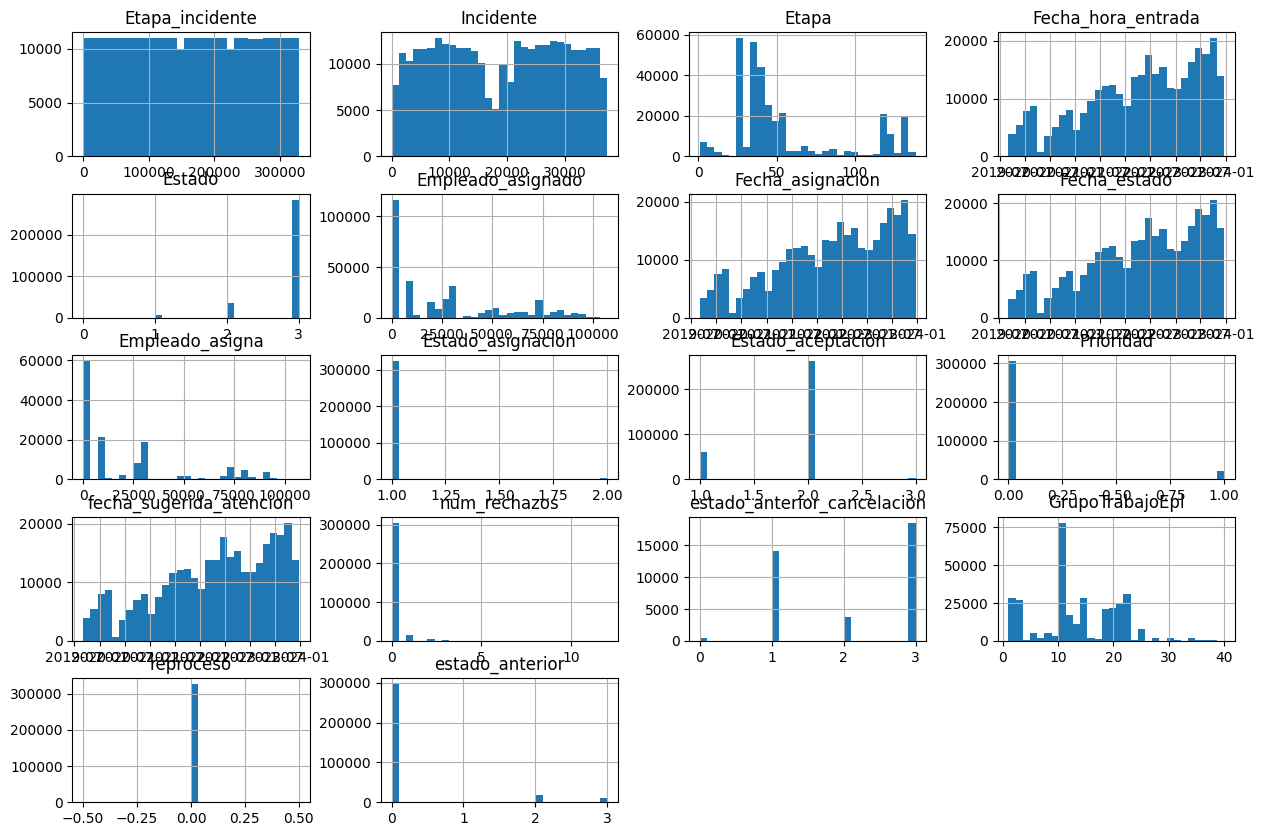

In [ ]:
raw_wf_etapa_incidente.hist(bins=30, figsize=(15, 10))

In [ ]:
silver_wf_etapa_incidente = raw_wf_etapa_incidente[[
    'Etapa_incidente',
    'Incidente',
    'Etapa',
    'Fecha_hora_entrada',
    'Estado',
    'Empleado_asignado',
    'Fecha_asignacion',
    'Fecha_estado',
    'Empleado_asigna',
    'Estado_asignacion',
    'Estado_aceptacion',
    'fecha_sugerida_atencion',
    'estado_anterior_cancelacion',
    'EnAtencion'
]].rename(columns={
    'Etapa_incidente': 'id_etapa_incidente',
    'Incidente': 'id_incidente',
    'Etapa': 'id_etapa',
    'Fecha_hora_entrada': 'fecha_hora_entrada',
    'Estado': 'estado',
    'Empleado_asignado': 'id_empleado_asignado',
    'Fecha_asignacion': 'fecha_asignacion',
    'Fecha_estado': 'fecha_estado',
    'Empleado_asigna': 'id_empleado_asigna',
    'Estado_asignacion': 'estado_asignacion',
    'Estado_aceptacion': 'estado_aceptacion',
    'EnAtencion': 'en_atencion'
})

In [ ]:
silver_wf_etapa_incidente['id_empleado_asignado'] = silver_wf_etapa_incidente['id_empleado_asignado'].astype('Int64')
silver_wf_etapa_incidente['id_empleado_asigna'] = silver_wf_etapa_incidente['id_empleado_asigna'].astype('Int64')
silver_wf_etapa_incidente['estado_anterior_cancelacion'] = silver_wf_etapa_incidente['estado_anterior_cancelacion'].astype('Int64')

In [ ]:
print(silver_wf_etapa_incidente.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326577 entries, 0 to 326576
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_etapa_incidente           326577 non-null  int64         
 1   id_incidente                 326577 non-null  int64         
 2   id_etapa                     326577 non-null  int64         
 3   fecha_hora_entrada           326577 non-null  datetime64[ns]
 4   estado                       326577 non-null  int64         
 5   id_empleado_asignado         324178 non-null  Int64         
 6   fecha_asignacion             324178 non-null  datetime64[ns]
 7   fecha_estado                 326577 non-null  datetime64[ns]
 8   id_empleado_asigna           137816 non-null  Int64         
 9   estado_asignacion            326577 non-null  int64         
 10  estado_aceptacion            326577 non-null  int64         
 11  fecha_sugerida_atencion   

In [ ]:
print(silver_wf_etapa_incidente.isnull().sum())

id_etapa_incidente                  0
id_incidente                        0
id_etapa                            0
fecha_hora_entrada                  0
estado                              0
id_empleado_asignado             2399
fecha_asignacion                 2399
fecha_estado                        0
id_empleado_asigna             188761
estado_asignacion                   0
estado_aceptacion                   0
fecha_sugerida_atencion             0
estado_anterior_cancelacion    289830
en_atencion                      4235
dtype: int64


In [ ]:
estado_mapping = {1: 'En proceso', 2: 'Cancelado', 3: 'Finalizado'}

In [ ]:
silver_wf_etapa_incidente['estado'] = silver_wf_etapa_incidente['estado'].map(estado_mapping).fillna('Desconocido')
silver_wf_etapa_incidente['estado_asignacion'] = silver_wf_etapa_incidente['estado_asignacion'].map(estado_mapping).fillna('Desconocido')
silver_wf_etapa_incidente['estado_aceptacion'] = silver_wf_etapa_incidente['estado_aceptacion'].map(estado_mapping).fillna('Desconocido')
silver_wf_etapa_incidente['estado_anterior_cancelacion'] = silver_wf_etapa_incidente['estado_anterior_cancelacion'].map(estado_mapping).fillna('Desconocido')

In [ ]:
silver_wf_etapa_incidente.head()

,id_etapa_incidente,id_incidente,id_etapa,fecha_hora_entrada,estado,id_empleado_asignado,fecha_asignacion,fecha_estado,id_empleado_asigna,estado_asignacion,estado_aceptacion,fecha_sugerida_atencion,estado_anterior_cancelacion,en_atencion
0,1,1,25,2019-09-03 11:24:15.383,Cancelado,2,2019-09-03 11:28:00.867,2021-03-06 18:05:22.503,2,Cancelado,Cancelado,2019-09-03 11:24:15.383,Finalizado,False
1,2,1,27,2019-09-03 15:56:58.433,Cancelado,2,2019-09-03 15:58:37.560,2021-03-06 18:05:22.503,2,Cancelado,Cancelado,2019-09-03 15:55:00.000,Finalizado,False
2,3,1,28,2019-09-03 15:59:49.700,Cancelado,2,2019-09-03 16:00:32.480,2021-03-06 18:05:22.503,2,Cancelado,Cancelado,2019-09-03 15:58:00.000,Finalizado,False
3,4,1,34,2019-09-03 16:01:59.293,Cancelado,2,2019-09-03 16:01:59.293,2021-03-06 18:05:22.503,<NA>,En proceso,Cancelado,2019-09-03 16:00:00.000,Finalizado,False
4,5,1,52,2019-09-03 16:02:31.873,Cancelado,2,2019-09-03 16:05:14.967,2021-03-06 18:05:22.503,2,Cancelado,Cancelado,2019-09-03 16:02:00.000,En proceso,False


In [ ]:
gold_wf_etapa_incidente = pd.merge(
    silver_wf_etapa_incidente,
    gold_tiempos,
    how='inner',
    on='id_etapa_incidente'
)

In [ ]:
gold_wf_etapa_incidente = pd.merge(
    silver_wf_etapa_incidente,
    gold_tiempos,
    how='inner',
    on='id_etapa_incidente'
)


In [ ]:
gold_wf_etapa_incidente

,id_etapa_incidente,id_incidente,id_etapa,fecha_hora_entrada,estado,id_empleado_asignado,fecha_asignacion,fecha_estado,id_empleado_asigna,estado_asignacion,estado_aceptacion,fecha_sugerida_atencion,estado_anterior_cancelacion,en_atencion,tiempo
0,1,1,25,2019-09-03 11:24:15.383,Cancelado,2,2019-09-03 11:28:00.867,2021-03-06 18:05:22.503,2,Cancelado,Cancelado,2019-09-03 11:24:15.383,Finalizado,False,272
1,2,1,27,2019-09-03 15:56:58.433,Cancelado,2,2019-09-03 15:58:37.560,2021-03-06 18:05:22.503,2,Cancelado,Cancelado,2019-09-03 15:55:00.000,Finalizado,False,3
2,3,1,28,2019-09-03 15:59:49.700,Cancelado,2,2019-09-03 16:00:32.480,2021-03-06 18:05:22.503,2,Cancelado,Cancelado,2019-09-03 15:58:00.000,Finalizado,False,2
3,4,1,34,2019-09-03 16:01:59.293,Cancelado,2,2019-09-03 16:01:59.293,2021-03-06 18:05:22.503,<NA>,En proceso,Cancelado,2019-09-03 16:00:00.000,Finalizado,False,1
4,5,1,52,2019-09-03 16:02:31.873,Cancelado,2,2019-09-03 16:05:14.967,2021-03-06 18:05:22.503,2,Cancelado,Cancelado,2019-09-03 16:02:00.000,En proceso,False,545013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326572,328973,37347,25,2023-12-19 17:09:53.317,En proceso,74501,2023-12-19 17:09:53.317,2023-12-19 17:09:53.317,<NA>,En proceso,En proceso,2023-12-19 17:09:53.260,Desconocido,False,0
326573,328974,36928,37,2023-12-19 17:15:01.643,Finalizado,79020,2023-12-19 17:15:20.677,2023-12-19 17:15:35.110,79020,En proceso,Cancelado,2023-12-19 17:12:00.000,Desconocido,False,0
326574,328975,37260,34,2023-12-19 17:15:15.883,En proceso,95149,2023-12-19 17:15:15.883,2023-12-19 17:15:15.883,<NA>,En proceso,En proceso,2023-12-19 16:19:00.000,Desconocido,None,0
326575,328976,36928,39,2023-12-19 17:15:35.157,Finalizado,79020,2023-12-19 17:16:06.760,2023-12-19 17:16:30.367,79020,En proceso,Cancelado,2023-12-19 17:15:00.000,Desconocido,False,1


In [ ]:
print(gold_wf_etapa_incidente.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326577 entries, 0 to 326576
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_etapa_incidente           326577 non-null  int64         
 1   id_incidente                 326577 non-null  int64         
 2   id_etapa                     326577 non-null  int64         
 3   fecha_hora_entrada           326577 non-null  datetime64[ns]
 4   estado                       326577 non-null  object        
 5   id_empleado_asignado         324178 non-null  Int64         
 6   fecha_asignacion             324178 non-null  datetime64[ns]
 7   fecha_estado                 326577 non-null  datetime64[ns]
 8   id_empleado_asigna           137816 non-null  Int64         
 9   estado_asignacion            326577 non-null  object        
 10  estado_aceptacion            326577 non-null  object        
 11  fecha_sugerida_atencion   

# Credit Factory

## Cotizacion

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_cotizacion = pd.read_sql(text("select CotizacionId, FechaCreacion, FechaEdicion, Estado, IdSucursal, IdCotizador, IdPantallaActual from CreditFactory.Cotizacion"), db_conn)

raw_cotizacion.head()

,CotizacionId,FechaCreacion,FechaEdicion,Estado,IdSucursal,IdCotizador,IdPantallaActual
0,3,2020-12-07 17:47:24.550,2020-12-07 17:47:24.997,1,0,2751,11004
1,4,2020-12-07 19:38:48.027,2020-12-17 15:58:10.693,1,0,2751,11004
2,5,2020-12-08 08:33:39.873,2020-12-17 19:22:15.943,10,0,2751,11003
3,6,2020-12-08 11:34:24.987,2020-12-08 11:34:25.377,1,0,2751,11004
4,7,2020-12-09 16:15:54.423,2021-01-19 07:30:07.700,2,0,2751,11002


In [ ]:
silver_cotizacion = raw_cotizacion[[
    'CotizacionId',
    'FechaCreacion',
    'FechaEdicion',
    'Estado',
    'IdSucursal',
    'IdCotizador',
    'IdPantallaActual'
    ]].rename(
    columns={
        'CotizacionId': 'id_cotizacion',
        'FechaCreacion': 'fecha_creacion',
        'FechaEdicion': 'fecha_edicion',
        'Estado': 'estado',
        'IdSucursal': 'id_sucursal',
        'IdCotizador': 'id_cotizador',
        'IdPantallaActual': 'id_pantalla_actual'
        }
)

In [ ]:
silver_cotizacion.head()

,id_cotizacion,fecha_creacion,fecha_edicion,estado,id_sucursal,id_cotizador,id_pantalla_actual
0,3,2020-12-07 17:47:24.550,2020-12-07 17:47:24.997,1,0,2751,11004
1,4,2020-12-07 19:38:48.027,2020-12-17 15:58:10.693,1,0,2751,11004
2,5,2020-12-08 08:33:39.873,2020-12-17 19:22:15.943,10,0,2751,11003
3,6,2020-12-08 11:34:24.987,2020-12-08 11:34:25.377,1,0,2751,11004
4,7,2020-12-09 16:15:54.423,2021-01-19 07:30:07.700,2,0,2751,11002


## Catalogo Detalle
Necesario para obtener los nombres de los estados

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_catalogo_detalle = pd.read_sql(text("select Valor, Texto, IdCatalogo from CreditFactory.Catalogo_Detalle"), db_conn)

raw_catalogo_detalle.head()

,Valor,Texto,IdCatalogo
0,CRC-P,Principal,1
1,CRG-P,Principal,2
2,CRU-P,Principal,3
3,1,Creación,4
4,2,Edición,4


In [ ]:
silver_catalogo_detalle = raw_catalogo_detalle[[
    'Valor',
    'Texto',
    'IdCatalogo'
    ]].rename(
    columns={
        'Valor': 'valor',
        'Texto': 'texto',
        'IdCatalogo': 'id_catalogo'
        }
)

In [ ]:
silver_catalogo_detalle.head()

,valor,texto,id_catalogo
2220,1,En proceso,29
2221,2,Desistido,29
2222,3,Rechazado,29
2223,4,En Aprobación,29
2224,5,En Trámite,29


In [ ]:
silver_catalogo_detalle = silver_catalogo_detalle[silver_catalogo_detalle['id_catalogo'] == 29]

## Cotizacion Historial
Historico de movimientos sobre la cotizacion

In [ ]:
query = '''
WITH COTIZACION_ACTUAL AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY ch.IdCotizacion ORDER BY Fecha DESC) AS row_number
    FROM CreditFactory.Cotizacion_Historial ch
)
SELECT * FROM COTIZACION_ACTUAL
WHERE row_number = 1 AND Estado IN (3, 10);
'''

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_cotizacion_historial = pd.read_sql(text(query), db_conn)

raw_cotizacion_historial.head()

,Id,Pantallas,IdOperacion,Fecha,IdCotizacion,IdUsuario,Estado,Comentario,row_number
0,240,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-17 19:22:15.943,5,0,10,Gestión: Aprobado,1
1,513,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-30 19:46:54.310,10,2,10,Gestión: Aprobado,1
2,209,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-17 16:22:13.507,8,2,10,Gestión: Aprobado,1
3,508,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-30 19:25:51.677,13,2,10,Gestión: Aprobado,1
4,366,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-24 14:29:19.480,17,2,10,Gestión: Aprobado,1


### Modelo pre-calificación

In [ ]:
cotizacion_historial = raw_cotizacion_historial.copy(deep=True)

In [ ]:
import json

In [ ]:
cotizacion_historial['Pantallas'] = cotizacion_historial['Pantallas'].apply(json.loads)

#### Product

In [ ]:
# Example: Extract 'Product' section into a new DataFrame
product_dataframes = []
for i, row in cotizacion_historial.iterrows():
    product_info = row['Pantallas'].get('Product')
    if product_info:
        product_df = pd.json_normalize(product_info['SubForms'][0]['Fields'])
        new_record = pd.DataFrame([{
            'Name': 'EstadoCotizacion',
            'Text': '',
            'Value': row['Estado'] ,
        }])
        product_df = pd.concat([product_df, new_record], ignore_index=True)
        product_df['IdCotizacion'] = row['IdCotizacion']
        product_dataframes.append(product_df)

In [ ]:
product_dataframes[0]

In [ ]:
pivoted_dataframes = []

for df in product_dataframes:
    df['TextValue'] = df['Text'].astype(str) + '-' + df['Value'].astype(str)
    pivoted_df = df.pivot_table(index='IdCotizacion', columns='Name', values='TextValue', aggfunc='first').reset_index()
    pivoted_df.columns.name = None  # Flatten the column names if needed
    pivoted_dataframes.append(pivoted_df)

# Concatenate all pivoted DataFrames into a single DataFrame
general_df = pd.concat(pivoted_dataframes, ignore_index=True)

In [ ]:
general_df.head()

,IdCotizacion,AbonoMonto,AbonoPor,Anio,AnioAuto,CanalAtencion,CancelacionesTerceros,CantLetrasDescontar,CantLetrasDescontarPromo,CasaPromotora,...,TipoPromocion,TipoVenta,Valor,Distribuidor,PromoId,Meses,SueldoMinimo,TasaGobierno,Estado,Origen
0,5,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1800.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1385.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0.00-,0.00-,2020-2020,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1090.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Al contado-C,1410.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Al contado-C,1385.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
general_df.to_csv('Product.csv', index=False)

NameError: name 'general_df' is not defined

##### Procesamiento product

In [ ]:
import pandas as pd

In [ ]:
import re

def extract_integer(value):
    numbers = re.findall(r'\d+', value)

    if numbers:
        return int(numbers[0])
    else:
        return None

In [ ]:
import re

def extract_decimal(value):
    decimals = re.findall(r'\d*\.\d+', value)

    if decimals:
        return float(decimals[0])
    else:
        return None

In [ ]:
raw_product = pd.read_csv('Product.csv')
raw_product.head()

,IdCotizacion,AbonoMonto,AbonoPor,Anio,AnioAuto,CanalAtencion,CancelacionesTerceros,CantLetrasDescontar,CantLetrasDescontarPromo,CasaPromotora,...,TipoPromocion,TipoVenta,Valor,Distribuidor,PromoId,Meses,SueldoMinimo,TasaGobierno,Estado,Origen
0,5,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1800.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1385.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0.00-,0.00-,2020-2020,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1090.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Al contado-C,1410.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Al contado-C,1385.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for column in raw_product.columns:
    value_counts = raw_product[column].value_counts()
    print(f"Value counts for '{column}':\n{value_counts}\n")

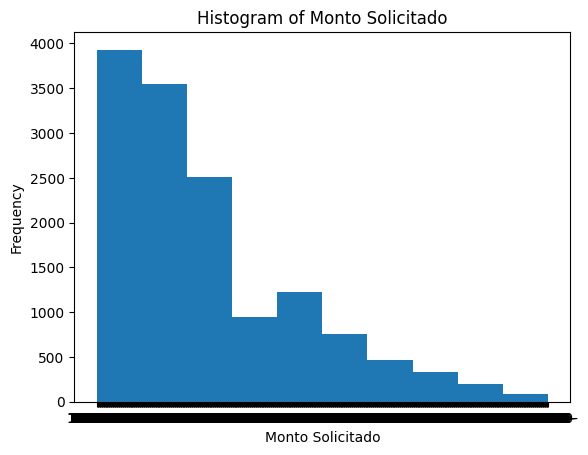

In [ ]:
## Rango de Monto Solicitado
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df'
plt.hist(raw_product['MontoSolicitado'])
plt.xlabel('Monto Solicitado')
plt.ylabel('Frequency')
plt.title('Histogram of Monto Solicitado')
plt.show()

In [ ]:
## Transformacion de año
raw_product['Anio'] = raw_product['Anio'].str.split('-').str[0]

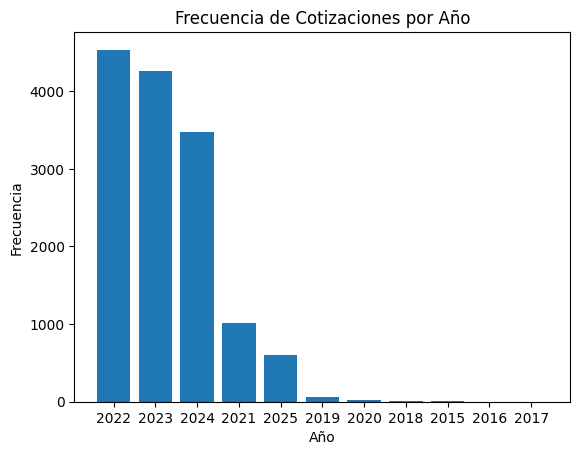

In [ ]:
# Agrupar los datos por el año y contar las ocurrencias
anio_counts = raw_product['Anio'].value_counts()

# Crear el gráfico de barras
plt.bar(anio_counts.index, anio_counts.values)
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Cotizaciones por Año')
plt.show()

In [ ]:
## Transformacion de descuento monto
raw_product['DescuentoMonto'] = raw_product['DescuentoMonto'].str.split('-').str[0]

In [ ]:
## Transformacion de descuento por
raw_product['DescuentoPor'] = raw_product['DescuentoPor'].apply(extract_decimal)

In [ ]:
## Transformacion de estado cotizacion
raw_product['EstadoCotizacion'] = raw_product['EstadoCotizacion'].astype('str')
raw_product['EstadoCotizacion'] = raw_product['EstadoCotizacion'].apply(extract_integer)

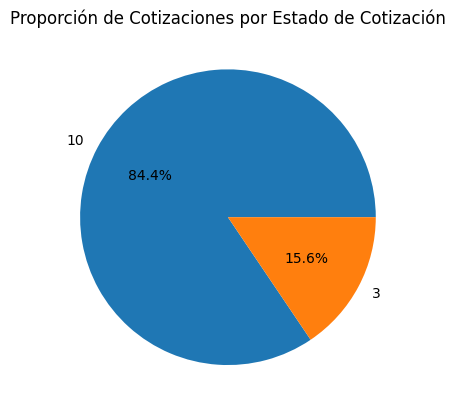

In [ ]:
# Get the counts of each 'EstadoCotizacion' value
estado_counts = raw_product['EstadoCotizacion'].value_counts().sort_values(ascending=False)

# Calculate the total number of cotizaciones
total_cotizaciones = len(raw_product)

# Calculate the proportion for each 'EstadoCotizacion' value
estado_proportions = estado_counts / total_cotizaciones

# Create a pie chart to visualize the proportions
plt.pie(estado_proportions, labels=estado_proportions.index, autopct='%1.1f%%')
plt.title('Proporción de Cotizaciones por Estado de Cotización')
plt.show()

In [ ]:
raw_product['FuenteNegocio'] = raw_product['FuenteNegocio'].apply(extract_integer)

In [ ]:
raw_product['Marca'] = raw_product['Marca'].str.split('-').str[0]

In [ ]:
raw_product['Modelo'] = raw_product['Modelo'].str.split('-').str[0]

In [ ]:
raw_product['MontoSolicitado'] = raw_product['MontoSolicitado'].apply(extract_integer)

In [ ]:
raw_product['Plazo'] = raw_product['Plazo'].apply(extract_integer)

In [ ]:
raw_product['PrimaMonto'] = raw_product['PrimaMonto'].apply(extract_decimal)

In [ ]:
raw_product['PrimaPor'] = raw_product['PrimaPor'].apply(extract_decimal)

In [ ]:
raw_product['Proposito'] = raw_product['Proposito'].astype('str')
raw_product['Proposito'] = raw_product['Proposito'].apply(extract_integer)

In [ ]:
raw_product['Tienda'] = raw_product['Tienda'].str.split('-').str[0]

In [ ]:
raw_product['TipoCliente'] = raw_product['TipoCliente'].str.split('-').str[0]

In [ ]:
raw_product['TipoPromocion'] = raw_product['TipoPromocion'].apply(extract_integer)

In [ ]:
raw_product['TipoVenta'] = raw_product['TipoVenta'].str.split('-').str[0]

In [ ]:
raw_product['Valor'] = raw_product['Valor'].apply(extract_integer)

In [ ]:
raw_product['Distribuidor'] = raw_product['Distribuidor'].str.split('-').str[-1]
raw_product['Distribuidor'] = raw_product['Distribuidor'].fillna('')

In [ ]:
raw_product['PromoId'] = raw_product['PromoId'].astype('str')
raw_product['PromoId'] = raw_product['PromoId'].apply(extract_integer)

In [ ]:
raw_product['Meses'] = raw_product['Meses'].astype('str')
raw_product['Meses'] = raw_product['Meses'].apply(extract_integer)

In [ ]:
raw_product['SueldoMinimo'] = raw_product['SueldoMinimo'].astype('str')
raw_product['SueldoMinimo'] = raw_product['SueldoMinimo'].apply(extract_integer)

In [ ]:
raw_product['TasaGobierno'] = raw_product['TasaGobierno'].astype('str')
raw_product['TasaGobierno'] = raw_product['TasaGobierno'].apply(extract_integer)

In [ ]:
raw_product['Estado'] = raw_product['Estado'].str.split('-').str[0]

In [ ]:
raw_product['Origen'] = raw_product['Origen'].str.split('-').str[0]

In [ ]:
raw_product.head()

,IdCotizacion,AbonoMonto,AbonoPor,Anio,AnioAuto,CanalAtencion,CancelacionesTerceros,CantLetrasDescontar,CantLetrasDescontarPromo,CasaPromotora,...,TipoPromocion,TipoVenta,Valor,Distribuidor,PromoId,Meses,SueldoMinimo,TasaGobierno,Estado,Origen
0,5,0.00-,0.00-,2019,-,None-None,0.00-,0-,0-,-,...,NaN,Credito,1800,,NaN,NaN,NaN,NaN,NaN,NaN
1,10,0.00-,0.00-,2019,-,None-None,0.00-,0-,0-,-,...,NaN,Credito,1385,,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0.00-,0.00-,2020,-,None-None,0.00-,0-,0-,-,...,NaN,Credito,1090,,NaN,NaN,NaN,NaN,NaN,NaN
3,13,0.00-,0.00-,2019,-,None-None,0.00-,0-,0-,-,...,NaN,Al contado,1410,,NaN,NaN,NaN,NaN,NaN,NaN
4,17,0.00-,0.00-,2019,-,None-None,0.00-,0-,0-,-,...,NaN,Al contado,1385,,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
silver_product = raw_product[[
    'IdCotizacion',
    'Anio',
    'DescuentoMonto',
    'DescuentoPor',
    'EstadoCotizacion',
    'FuenteNegocio',
    'Marca',
    'MontoSolicitado',
    'Plazo',
    'PrimaMonto',
    'PrimaPor',
    'Proposito',
    'TipoCliente',
    'TipoPromocion',
    'TipoVenta',
    'Valor',
    'Meses',
    'SueldoMinimo',
    'TasaGobierno',
    'Estado'
]]

In [ ]:
silver_product.to_csv('SilverProduct.csv', index=False)

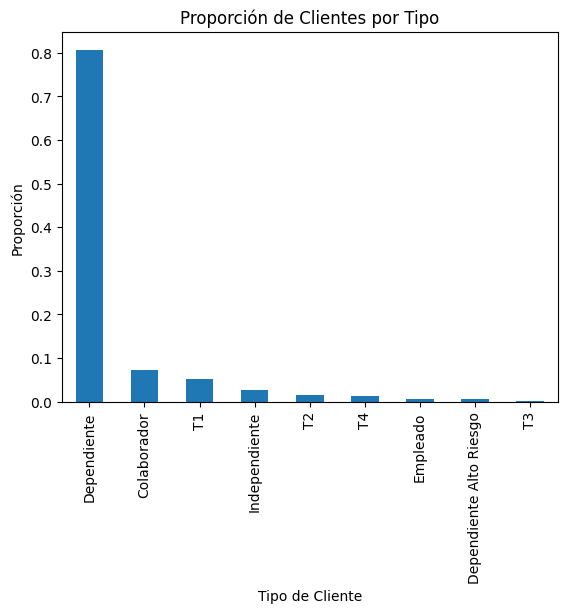

In [ ]:
# Contar las ocurrencias de cada tipo de cliente
tipo_cliente_counts = silver_product['TipoCliente'].value_counts()

# Calcular las proporciones
total_clientes = len(silver_product)
proporciones = tipo_cliente_counts / total_clientes

# Crear el gráfico de barras
proporciones.plot(kind='bar')
plt.title('Proporción de Clientes por Tipo')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Proporción')
plt.show()

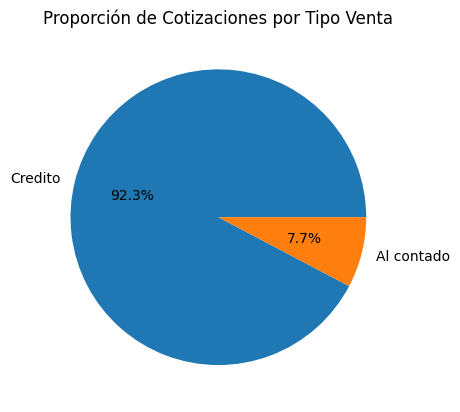

In [ ]:
estado_counts = silver_product['TipoVenta'].value_counts().sort_values(ascending=False)

# Calculate the total number of cotizaciones
total_cotizaciones = len(silver_product)

# Calculate the proportion for each 'EstadoCotizacion' value
estado_proportions = estado_counts / total_cotizaciones

# Create a pie chart to visualize the proportions
plt.pie(estado_proportions, labels=estado_proportions.index, autopct='%1.1f%%')
plt.title('Proporción de Cotizaciones por Tipo Venta')
plt.show()

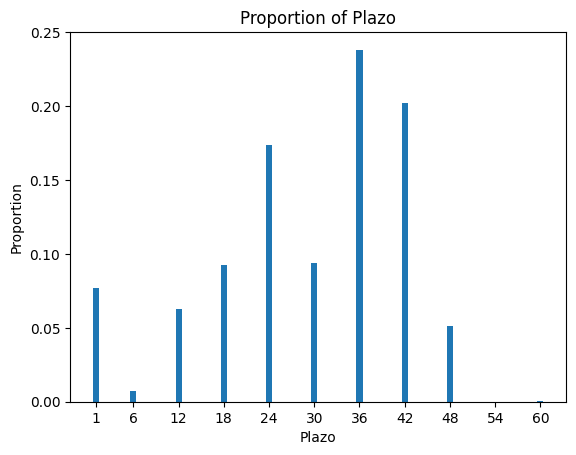

In [ ]:
# Count occurrences of each "Plazo" value
plazo_counts = silver_product['Plazo'].value_counts()

# Calculate total number of observations
total_observations = len(silver_product)

# Calculate proportions
proportions = plazo_counts / total_observations

# Create a bar chart
plt.bar(proportions.index, proportions.values)
plt.xticks(proportions.index)  # Display exact values on the x-axis
plt.title('Proportion of Plazo')
plt.xlabel('Plazo')
plt.ylabel('Proportion')
plt.show()

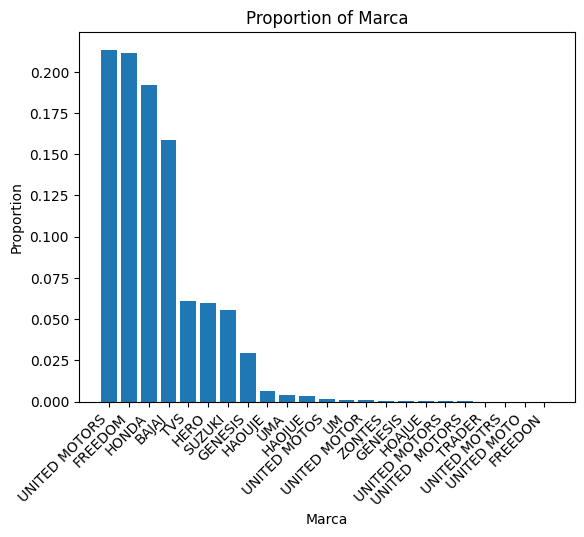

In [ ]:
marca_counts = silver_product['Marca'].value_counts()

# Calculate total number of observations
total_observations = len(silver_product)

# Calculate proportions
proportions = marca_counts / total_observations

# Create a bar chart
plt.bar(proportions.index, proportions.values)
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align right
plt.title('Proportion of Marca')
plt.xlabel('Marca')
plt.ylabel('Proportion')
plt.show()

##### Fin procesamiento product

In [ ]:
del product_dataframes
del pivoted_dataframes
del general_df

In [ ]:
financial_dataframes = []
for i, row in cotizacion_historial.iterrows():
    product_info = row['Pantallas'].get('Financial')
    if product_info:
        product_df = pd.json_normalize(product_info['SubForms'][0]['Fields'])
        new_record = pd.DataFrame([{
            'Name': 'EstadoCotizacion',
            'Text': '',
            'Value': row['Estado'] ,
        }])
        product_df = pd.concat([product_df, new_record], ignore_index=True)
        product_df['IdCotizacion'] = row['IdCotizacion']
        financial_dataframes.append(product_df)

In [ ]:
pivoted_dataframes = []

for df in financial_dataframes:
    df['TextValue'] = df['Text'].astype(str) + '-' + df['Value'].astype(str)
    pivoted_df = df.pivot_table(index='IdCotizacion', columns='Name', values='TextValue', aggfunc='first').reset_index()
    pivoted_df.columns.name = None  # Flatten the column names if needed
    pivoted_dataframes.append(pivoted_df)

# Concatenate all pivoted DataFrames into a single DataFrame
general_df = pd.concat(pivoted_dataframes, ignore_index=True)

In [ ]:
general_df.head()

,IdCotizacion,ActividadEmpresa,Anios,AntiguedadEmpresa,AntiguedadLaboral,CantidadEmpleadosEmpresa,CantidadLocales,CapacidadDescuento,Cargo,CelularJefe,...,TelefonoTrabajo,TipoContrato,TipoLocalEmpresa,TipoSectorEmpresa,TipoSueldo,TrabajoAntCargo,TrabajoAntEmpresa,TrabajoAntFechaFin,TrabajoAntFechaInicio,TrabajoAntUltSalario
0,5,Prueba-,0-,3-,0-,2-,2-,0.00-,-,-,...,-,-,local-,sector-,-,-,-,-,-,0.00-
1,10,VENTAS AL POR MAYOR-,0-,147-,0-,15-,4-,0.00-,-,-,...,-,-,VENTAS-,VENTAS-,-,-,-,-,-,0.00-
2,8,VENTAS AL POR MAYOR-,0-,0-,0-,0-,0-,0.00-,CONTADOR JR.-,9000900-,...,8000900-,-5,-,-,-3,-,-,-,-,0.00-
3,13,ABC-,0-,0-,0-,0-,0-,0.00-,Analista-,7293293-,...,34902923-,-3,-,-,-2,-,-,-,-,0.00-
4,17,-,-,0-,20-,0-,0-,0.00-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [ ]:
general_df.to_csv('Financial.csv', index=False)

In [ ]:
del financial_dataframes
del pivoted_dataframes
del general_df

#### Client

In [ ]:
client_dataframes = []
for i, row in cotizacion_historial.iterrows():
    product_info = row['Pantallas'].get('Client')
    if product_info:
        client_df = pd.json_normalize(product_info['SubForms'][0]['Fields'])
        new_record = pd.DataFrame([{
            'Name': 'EstadoCotizacion',
            'Text': '',
            'Value': row['Estado'] ,
        }])
        client_df = pd.concat([client_df, new_record], ignore_index=True)
        client_df['IdCotizacion'] = row['IdCotizacion']
        client_dataframes.append(client_df)

In [ ]:
pivoted_dataframes = []

for df in client_dataframes:
    df['TextValue'] = df['Text'].astype(str) + '-' + df['Value'].astype(str)
    pivoted_df = df.pivot_table(index='IdCotizacion', columns='Name', values='TextValue', aggfunc='first').reset_index()
    pivoted_df.columns.name = None  # Flatten the column names if needed
    pivoted_dataframes.append(pivoted_df)

# Concatenate all pivoted DataFrames into a single DataFrame
general_df = pd.concat(pivoted_dataframes, ignore_index=True)

In [ ]:
general_df.head()

,Id,AnioCarro,ApellidoCasada,CallePropiedad,CargoPep,CiudadPropiedad,ConocidoPor,Correo,DireccionAdicional,DireccionCliente,...,TiempoViviendo,TieneCarro,TienePropiedad,TipoDireccion,TipoIdentificador,TipoPropiedad,TipoVivienda,ValorCarro,ValorPropiedad,DepartamentoResidencia
0,160308,-,-,-,None-,-,None-,Josefrancisco25@gmail.com-,None-,".., ., COLONIA SAN JUAN BAUTISTA, CASERIO EL C...",...,12-,NO-N,NO-N,None-2,None-46500,-,None-3,-,-,NaN
1,250641,-,-,-,None-,-,None-,Josericardocampos199405@gmail.com-,None-,"., ., ., ., LA PAZ, SAN PEDRO NONUALCO, Candel...",...,160-,NO-N,NO-N,None-2,None-46500,-,None-3,-,-,NaN
2,154779,-,-,-,None-,-,None-,marisol.gonzalez@essa.com.sv-,None-,"CL F, 3RA ETAPA POL P, URB EL MILAGRO, NO 51, ...",...,120-,NO-N,NO-N,None-2,None-46500,-,None-3,-,-,NaN
3,304605,-,-,-,None-,-,None-,Juanramirez1992@gmail.com-,None-,"., ., .CALL PRI, EN EL CENTRO MERCADO DE JUCUA...",...,120-,NO-N,NO-N,None-2,None-46500,-,None-3,-,-,NaN
4,52111,-,-,-,None-,-,None-,ANGELRN.MR@GMAIL.COM-,None-,"., POL K, RES CIUDAD MARSELLA QUARTIER 4, CASA...",...,6-,NO-N,NO-N,None-2,None-46500,-,None-5,-,-,NaN


In [ ]:
general_df.to_csv('Client.csv', index=False)

In [ ]:
del product_dataframes
del pivoted_dataframes
del general_df

#### Carga

In [ ]:
import pandas as pd

In [ ]:
raw_client = pd.read_csv('Client.csv')
raw_client.head()

,Id,AnioCarro,ApellidoCasada,CallePropiedad,CargoPep,CiudadPropiedad,ConocidoPor,Correo,DireccionAdicional,DireccionCliente,...,TiempoViviendo,TieneCarro,TienePropiedad,TipoDireccion,TipoIdentificador,TipoPropiedad,TipoVivienda,ValorCarro,ValorPropiedad,DepartamentoResidencia
0,160308,-,-,-,None-,-,None-,Josefrancisco25@gmail.com-,None-,".., ., COLONIA SAN JUAN BAUTISTA, CASERIO EL C...",...,12-,NO-N,NO-N,None-2,None-46500,-,None-3,-,-,NaN
1,250641,-,-,-,None-,-,None-,Josericardocampos199405@gmail.com-,None-,"., ., ., ., LA PAZ, SAN PEDRO NONUALCO, Candel...",...,160-,NO-N,NO-N,None-2,None-46500,-,None-3,-,-,NaN
2,154779,-,-,-,None-,-,None-,marisol.gonzalez@essa.com.sv-,None-,"CL F, 3RA ETAPA POL P, URB EL MILAGRO, NO 51, ...",...,120-,NO-N,NO-N,None-2,None-46500,-,None-3,-,-,NaN
3,304605,-,-,-,None-,-,None-,Juanramirez1992@gmail.com-,None-,"., ., .CALL PRI, EN EL CENTRO MERCADO DE JUCUA...",...,120-,NO-N,NO-N,None-2,None-46500,-,None-3,-,-,NaN
4,52111,-,-,-,None-,-,None-,ANGELRN.MR@GMAIL.COM-,None-,"., POL K, RES CIUDAD MARSELLA QUARTIER 4, CASA...",...,6-,NO-N,NO-N,None-2,None-46500,-,None-5,-,-,NaN


In [ ]:
client = raw_client.copy(deep = True)

In [ ]:
for column in client.columns:
    value_counts = client[column].value_counts()
    print(f"Value counts for '{column}':\n{value_counts}\n")

In [ ]:
bronze_client = client[[
    'AnioCarro',
    'CiudadPropiedad',
    'ConocidoPor', # Transformarlo a variable que indique si es que tiene referencia o no
    'Edad',
    'EstadoCivilReal',
    'Nacionalidad',
    'NivelEstudios',
    'NoDependientes',
    'NoSeguroSocial',
    'Profesion',
    'TieneCarro',
    'TipoDireccion'
]]

In [ ]:
import re

def extract_integer(value):
    numbers = re.findall(r'\d+', value)

    if numbers:
        return int(numbers[0])
    else:
        return None

In [ ]:
import re

def extract_decimal(value):
    decimals = re.findall(r'\d*\.\d+', value)

    if decimals:
        return float(decimals[0])
    else:
        return None

In [ ]:
silver_client = pd.DataFrame()

In [ ]:
silver_client['Edad'] = bronze_client['Edad'].apply(extract_integer)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar_chart(df, column_name):
    """
    Plots a bar chart for a specified column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to plot.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column_name, data=df)

    plt.title(f'Distribución de {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Conteo')

    plt.xticks(rotation=45)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_donut_chart(df, column_name):
    """
    Plots a donut chart for a specified column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to plot.
    """# Get the value counts of the column
    counts = df[column_name].value_counts()

    # Plot the donut chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(counts)), wedgeprops=dict(width=0.3))

    plt.title(f'Distribución de {column_name}')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_horizontal_bar_chart(df, column_name):
    """
    Plots a horizontal bar chart for a specified column in a DataFrame with value counts and percentages displayed inside the bars.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to plot.
    """# Get the value counts of the column
    counts = df[column_name].value_counts()

    # Calculate percentages
    percentages = counts / counts.sum() * 100# Plot the horizontal bar chart
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(y=counts.index, x=counts.values)

    # Add value labels (count and percentage) inside the bars
    for index, (count, percentage) in enumerate(zip(counts.values, percentages)):
        label = f'{count} ({percentage:.1f}%)'
        ax.text(count, index, label, va='center')

    plt.title(f'Distribución de {column_name}')
    plt.xlabel('Conteo')
    plt.ylabel(column_name)

    plt.show()


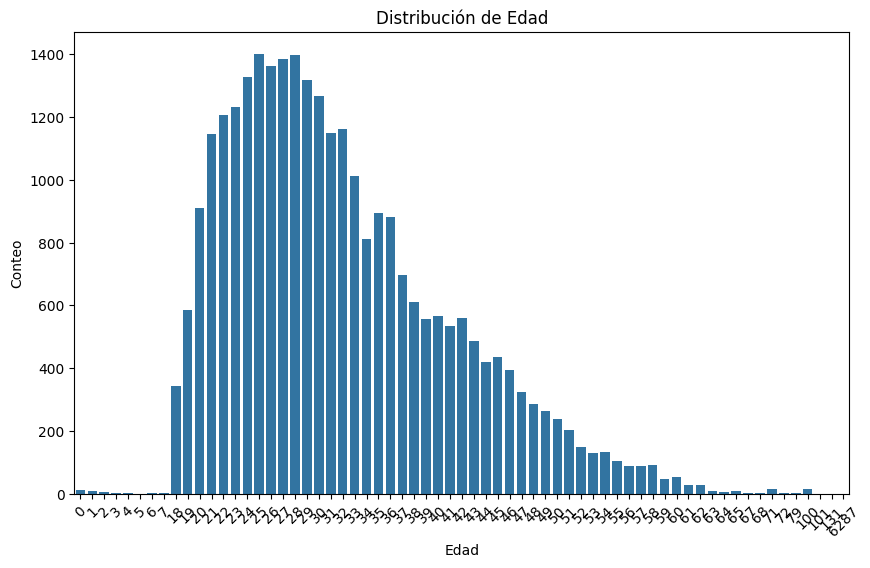

In [ ]:
plot_bar_chart(silver_client, 'Edad')

In [ ]:
silver_client['EstadoCivilReal'] = bronze_client['EstadoCivilReal'].apply(extract_integer)

In [ ]:
estado_civil_mapping = {
    1.0: 'Soltero',
    2.0: 'Casado',
    3.0: 'Viudo',
    4.0: 'Unión libre',
    5.0: 'Divorciado',
    6.0: 'Acompañado',
    7.0: 'Desconocido'
}

In [ ]:
silver_client['EstadoCivilReal'] = silver_client['EstadoCivilReal'].map(estado_civil_mapping)

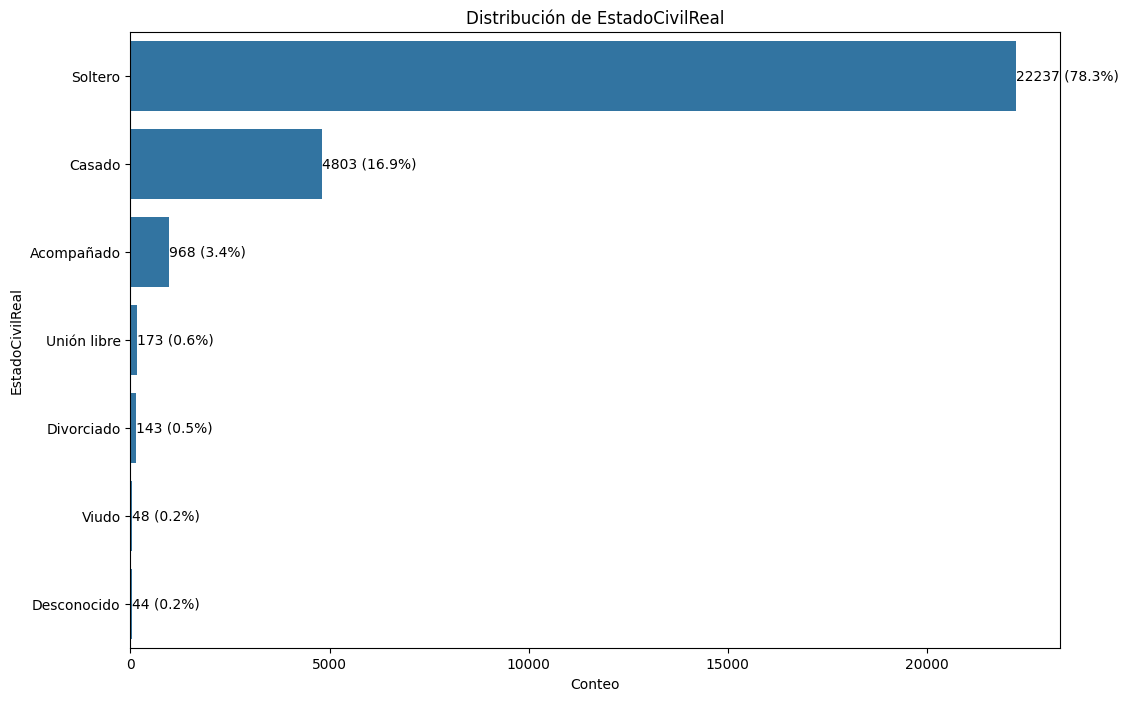

In [ ]:
plot_horizontal_bar_chart(silver_client, 'EstadoCivilReal')

In [ ]:
def extract_country_code(nacionalidad):
    parts = nacionalidad.split('-')
    return parts[1] if len(parts) > 1 else None

In [ ]:
silver_client['Nacionalidad'] = bronze_client['Nacionalidad'].apply(extract_country_code)

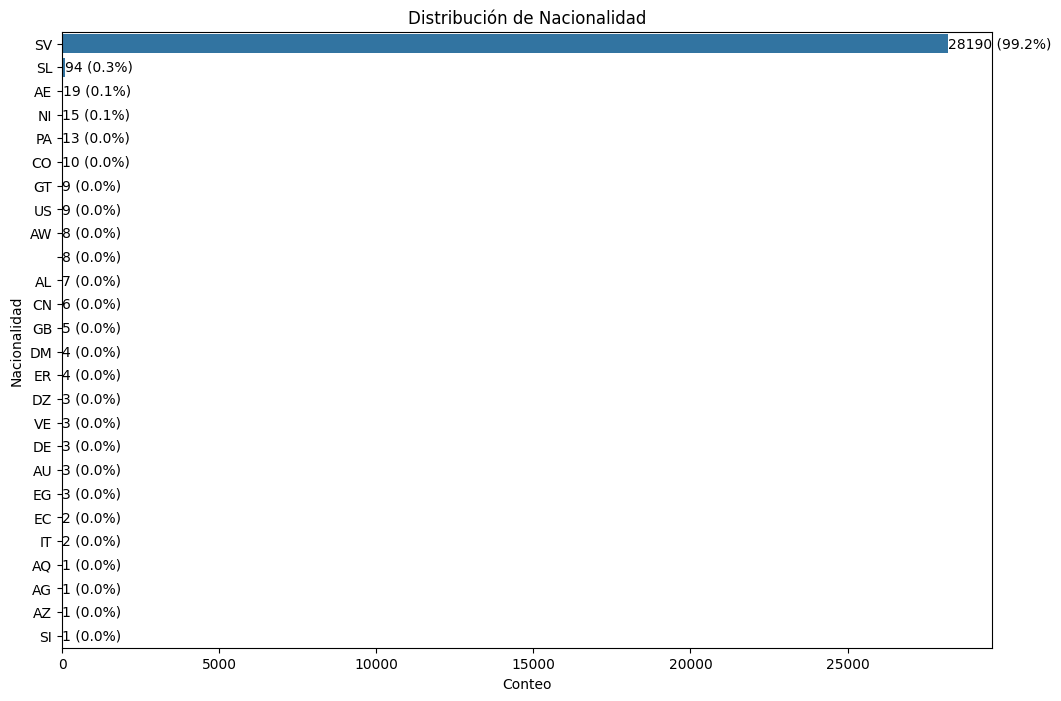

In [ ]:
plot_horizontal_bar_chart(silver_client, 'Nacionalidad')

In [ ]:
# Mapping based on the values provided
education_level_mapping = {
    1.0: 'Bachillerato',
    2.0: 'Básico',
    3.0: 'Ninguno',
    4.0: 'Universitario',
    5.0: 'No aplica'
}


In [ ]:
silver_client['NivelEstudios'] = bronze_client['NivelEstudios'].apply(extract_integer)

In [ ]:
silver_client['NivelEstudios'] = silver_client['NivelEstudios'].map(education_level_mapping)

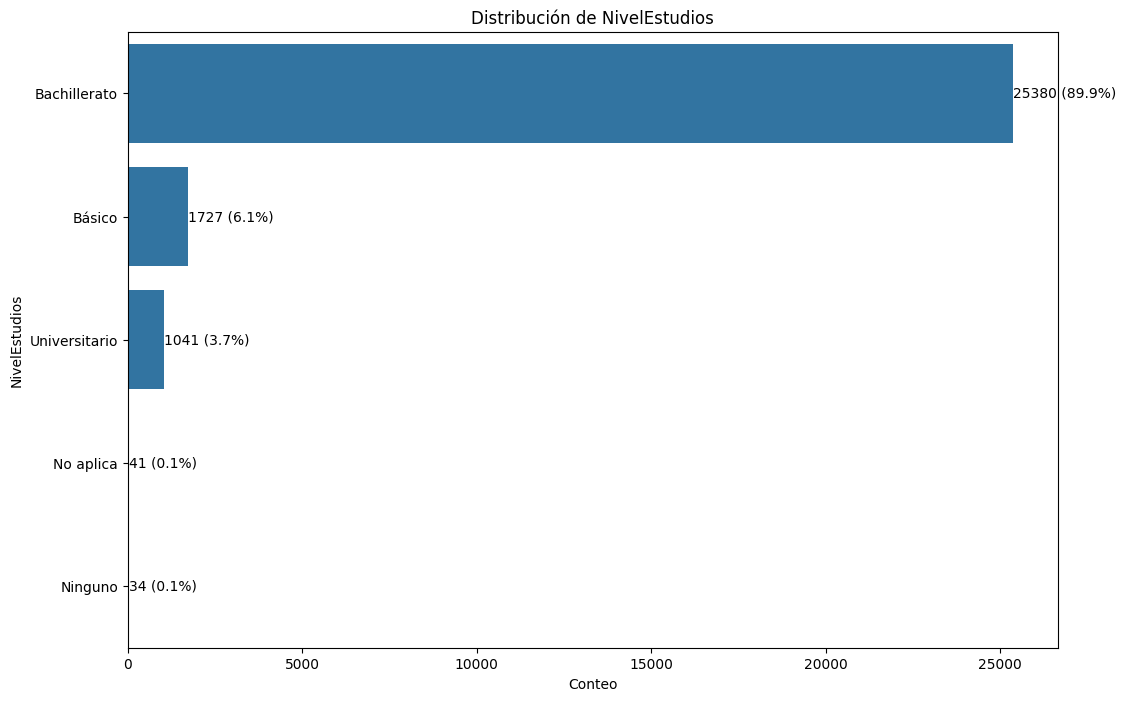

In [ ]:
plot_horizontal_bar_chart(silver_client, 'NivelEstudios')

In [ ]:
def clean_value(value):
    if '-' in value:
        return value.split('-')[0]
    return value

In [ ]:
silver_client['TieneCarro'] = bronze_client['TieneCarro'].apply(clean_value)

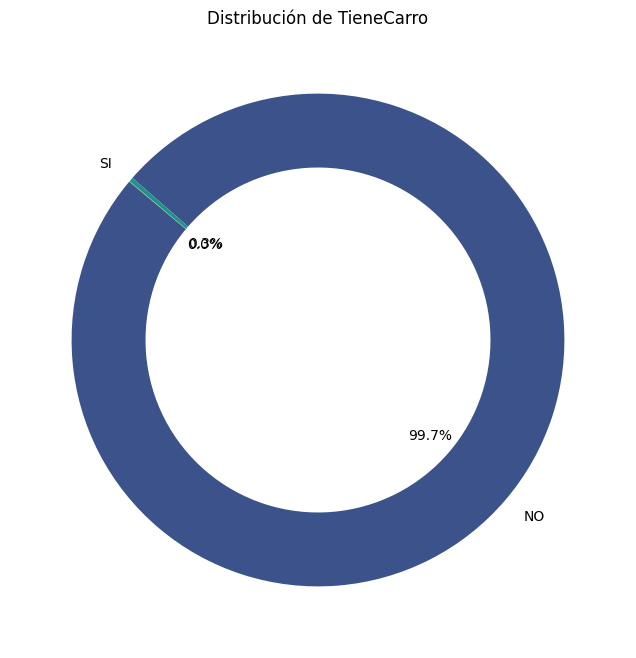

In [ ]:
plot_donut_chart(silver_client, 'TieneCarro')

In [ ]:
def categorize_year(year):
    if year == -1:
        return 'No tiene'
    current_year = pd.Timestamp.now().year
    if year > current_year - 5:
        return 'Moderno'
    elif year > current_year - 15:
        return 'Viejo'
    else:
        return 'Muy viejo'

In [ ]:
silver_client['anio_carro'] = client['AnioCarro'].apply(extract_year)
silver_client['anio_carro'].fillna(-1, inplace=True)
silver_client['categoria_carro'] = silver_client['anio_carro'].apply(categorize_year)

In [ ]:
distribution = silver_client['categoria_carro'].value_counts()
print(distribution)

categoria_carro
No tiene     28342
Muy viejo       46
Viejo           29
Moderno          7
Name: count, dtype: int64


#### Financial

##### Procesamiento Financial

In [ ]:
import pandas as pd

In [ ]:
raw_financial = pd.read_csv('Financial.csv')
raw_financial.head()

,IdCotizacion,ActividadEmpresa,Anios,AntiguedadEmpresa,AntiguedadLaboral,CantidadEmpleadosEmpresa,CantidadLocales,CapacidadDescuento,Cargo,CelularJefe,...,TelefonoTrabajo,TipoContrato,TipoLocalEmpresa,TipoSectorEmpresa,TipoSueldo,TrabajoAntCargo,TrabajoAntEmpresa,TrabajoAntFechaFin,TrabajoAntFechaInicio,TrabajoAntUltSalario
0,5,Prueba-,0-,3-,0-,2-,2-,0.00-,-,-,...,-,-,local-,sector-,-,-,-,-,-,0.00-
1,10,VENTAS AL POR MAYOR-,0-,147-,0-,15-,4-,0.00-,-,-,...,-,-,VENTAS-,VENTAS-,-,-,-,-,-,0.00-
2,8,VENTAS AL POR MAYOR-,0-,0-,0-,0-,0-,0.00-,CONTADOR JR.-,9000900-,...,8000900-,-5,-,-,-3,-,-,-,-,0.00-
3,17,-,-,0-,20-,0-,0-,0.00-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,13,ABC-,0-,0-,0-,0-,0-,0.00-,Analista-,7293293-,...,34902923-,-3,-,-,-2,-,-,-,-,0.00-


In [ ]:
raw_financial['ActividadEmpresa'] = raw_financial['ActividadEmpresa'].str.split('-').str[0]


In [ ]:
raw_financial['AntiguedadEmpresa'] = raw_financial['AntiguedadEmpresa'].apply(extract_integer)

In [ ]:
raw_financial['AntiguedadLaboral'] = raw_financial['AntiguedadLaboral'].apply(extract_integer)

In [ ]:
raw_financial['Cargo'] = raw_financial['Cargo'].str.split('-').str[0]

In [ ]:
raw_financial['Detalle'] = raw_financial['Detalle'].str.split('-').str[0]

In [ ]:
raw_financial['DiaPago'] = raw_financial['DiaPago'].apply(extract_integer)

In [ ]:
raw_financial['FormaPago'] = raw_financial['FormaPago'].apply(extract_integer)

In [ ]:
import re

def extract_number(value):
    cleaned_value = value.strip().strip('-')

    if not cleaned_value or cleaned_value == '--':
        return None

    cleaned_value = cleaned_value.replace(',', '')

    match = re.match(r'^(\d+(\.\d*)?)$', cleaned_value)
    if match:
        return float(match.group(1))

    match = re.match(r'^\d+$', cleaned_value)
    if match:
        return int(match.group(0))

    return None

In [ ]:
raw_financial['IngresoFijo'] = raw_financial['IngresoFijo'].apply(extract_number)

In [ ]:
raw_financial['IngresoVariable'] = raw_financial['IngresoVariable'].apply(extract_number)

In [ ]:
raw_financial['IngresoFijo'] = raw_financial['IngresoFijo'].fillna(0)

In [ ]:
raw_financial['IngresoVariable'] = raw_financial['IngresoVariable'].fillna(0)

In [ ]:
raw_financial['IngresoTotal'] = raw_financial['IngresoFijo'] + raw_financial['IngresoVariable']

In [ ]:
raw_financial['SalarioMensual'] = raw_financial['SalarioMensual'].apply(extract_number)

In [ ]:
raw_financial['TipoContrato'] = raw_financial['TipoContrato'].str.split('-').str[1]

In [ ]:
raw_financial['TipoLocalEmpresa'] = raw_financial['TipoLocalEmpresa'].str.split('-').str[0]

In [ ]:
raw_financial['TipoSueldo'] = raw_financial['TipoSueldo'].str.split('-').str[1]

In [ ]:
raw_financial['TipoContrato'] = raw_financial['TipoContrato'].fillna(0)

In [ ]:
raw_financial['TipoSueldo'] = raw_financial['TipoSueldo'].fillna(0)

In [ ]:
silver_financial = raw_financial[[
    'IdCotizacion',
    'ActividadEmpresa',
    'AntiguedadEmpresa',
    'AntiguedadLaboral',
    'IngresoFijo',
    'IngresoVariable',
    'IngresoTotal',
    'SalarioMensual',
    'TipoContrato',
    'TipoLocalEmpresa',
    'TipoSueldo'
]]

In [ ]:
silver_financial.to_csv('SilverFinancial.csv', index=False)

In [ ]:
silver_financial.head()

,IdCotizacion,ActividadEmpresa,AntiguedadEmpresa,AntiguedadLaboral,IngresoFijo,IngresoVariable,IngresoTotal,SalarioMensual,TipoContrato,TipoLocalEmpresa,TipoSueldo
0,5,Prueba,3,0,0.00,0.0,0.00,0.0,,local,
1,10,VENTAS AL POR MAYOR,147,0,0.00,0.0,0.00,0.0,,VENTAS,
2,8,VENTAS AL POR MAYOR,0,0,950.45,100.0,1050.45,0.0,5,,3
3,17,,0,20,0.00,0.0,0.00,852.0,,,
4,13,ABC,0,0,1000.00,500.0,1500.00,0.0,3,,2


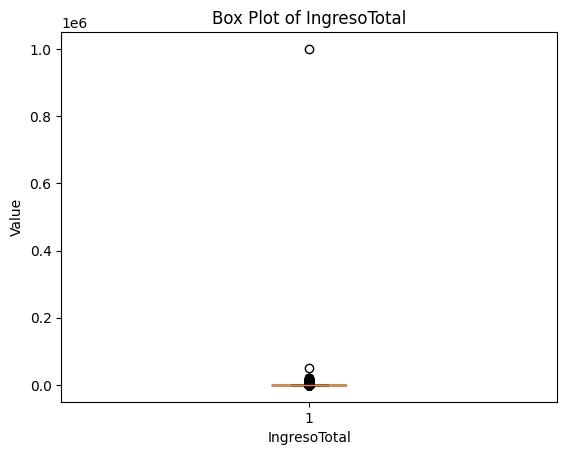

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'raw_financial' DataFrame defined
plt.boxplot(raw_financial['IngresoTotal'])
plt.xlabel('IngresoTotal')
plt.ylabel('Value')
plt.title('Box Plot of IngresoTotal')
plt.show()

In [ ]:
biggest_ingreso_total = silver_financial['IngresoTotal'].max()

print(biggest_ingreso_total)

1000000.0


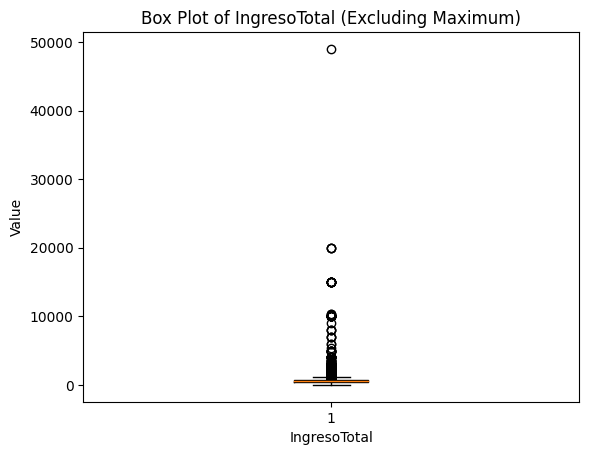

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'raw_financial'

# Find the index of the maximum value
max_index = silver_financial['IngresoTotal'].idxmax()

# Remove the maximum value
data_without_max = silver_financial['IngresoTotal'].drop(max_index)

# Create the box plot
plt.boxplot(data_without_max)
plt.xlabel('IngresoTotal')
plt.ylabel('Value')
plt.title('Box Plot of IngresoTotal (Excluding Maximum)')
plt.show()

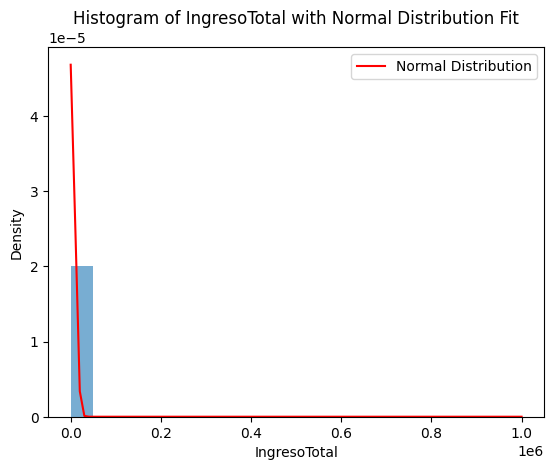

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming your DataFrame is named 'silver_financial'

# Calculate mean and standard deviation of IngresoTotal
mean_ingreso_total = silver_financial['IngresoTotal'].mean()
std_ingreso_total = silver_financial['IngresoTotal'].std()

# Generate x values for the normal distribution curve
x = np.linspace(min(silver_financial['IngresoTotal']), max(silver_financial['IngresoTotal']), 100)

# Calculate the probability density function (PDF) of the normal distribution
y = norm.pdf(x, mean_ingreso_total, std_ingreso_total)

# Plot histogram and normal distribution curve
plt.hist(silver_financial['IngresoTotal'], bins=20, density=True, alpha=0.6)
plt.plot(x, y, color='red', label='Normal Distribution')
plt.xlabel('IngresoTotal')
plt.ylabel('Density')
plt.title('Histogram of IngresoTotal with Normal Distribution Fit')
plt.legend()
plt.show()

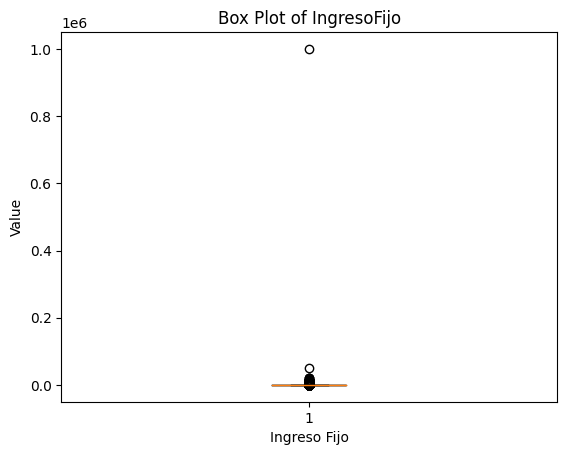

In [ ]:
plt.boxplot(silver_financial['IngresoFijo'])
plt.xlabel('Ingreso Fijo')
plt.ylabel('Value')
plt.title('Box Plot of IngresoFijo')
plt.show()

In [ ]:
biggest_ingreso_total = silver_financial['IngresoFijo'].max()

print(biggest_ingreso_total)

1000000.0


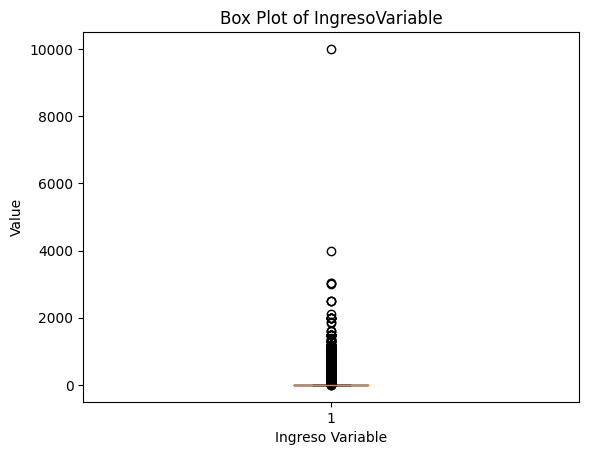

In [ ]:
plt.boxplot(silver_financial['IngresoVariable'])
plt.xlabel('Ingreso Variable')
plt.ylabel('Value')
plt.title('Box Plot of IngresoVariable')
plt.show()

In [ ]:
biggest_ingreso_total = silver_financial['IngresoVariable'].max()

print(biggest_ingreso_total)

10000.0


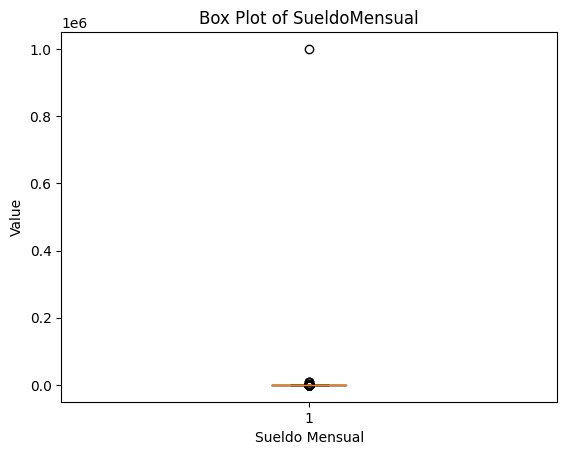

In [ ]:
plt.boxplot(silver_financial['SalarioMensual'])
plt.xlabel('Sueldo Mensual')
plt.ylabel('Value')
plt.title('Box Plot of SueldoMensual')
plt.show()

In [ ]:
biggest_ingreso_total = silver_financial['SalarioMensual'].max()

print(biggest_ingreso_total)

1000000.0


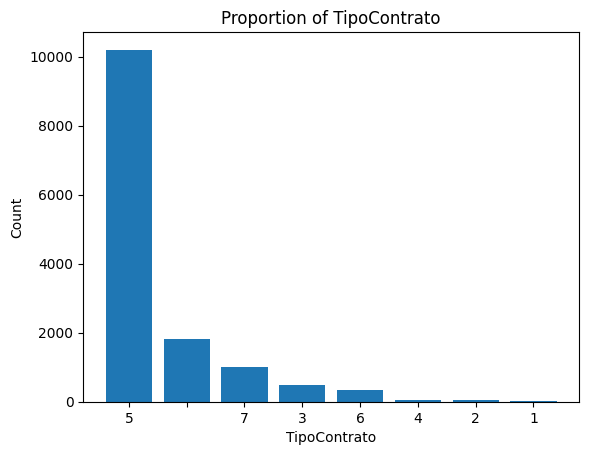

In [ ]:
tipo_contrato_counts = silver_financial['TipoContrato'].value_counts()
plt.bar(tipo_contrato_counts.index, tipo_contrato_counts)
plt.xlabel('TipoContrato')
plt.ylabel('Count')
plt.title('Proportion of TipoContrato')
plt.show()

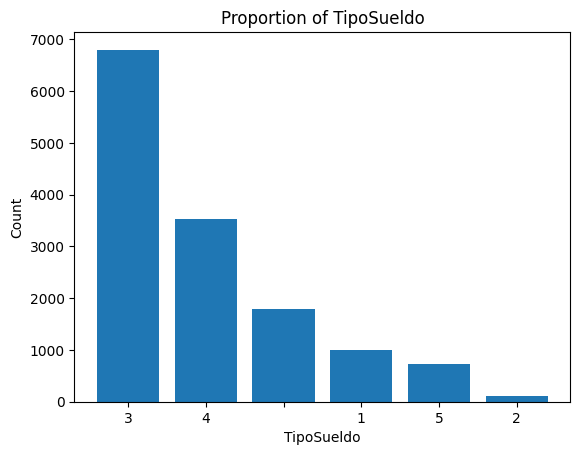

In [ ]:
tipo_sueldo_counts = silver_financial['TipoSueldo'].value_counts()
plt.bar(tipo_sueldo_counts.index, tipo_sueldo_counts)
plt.xlabel('TipoSueldo')
plt.ylabel('Count')
plt.title('Proportion of TipoSueldo')
plt.show()

##### Fin procesamiento financial

### Procesamiento

In [ ]:
silver_cotizacion_historial = raw_cotizacion_historial[[
    'Id',
    'Pantallas',
    'IdOperacion',
    'Fecha',
    'IdCotizacion',
    'Estado'
    ]].rename(
    columns={
        'Id': 'id_cotizacion_historial',
        'Pantallas': 'pantallas',
        'IdOperacion': 'id_operacion',
        'Fecha': 'fecha',
        'IdCotizacion': 'id_cotizacion',
        'Estado': 'estado'
        }
)

In [ ]:
silver_cotizacion_historial.head()

,id_cotizacion_historial,pantallas,id_operacion,fecha,id_cotizacion,estado
0,7,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 17:47:24.560,3,1
1,8,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",4,2020-12-07 17:47:24.560,3,1
2,9,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 17:47:24.570,3,1
3,10,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 19:38:48.090,4,1
4,11,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",4,2020-12-07 19:38:48.107,4,1


In [ ]:
silver_cotizacion_historial['id_cotizacion_historial'] = silver_cotizacion_historial['id_cotizacion_historial'].astype(int)
silver_cotizacion_historial['id_operacion'] = silver_cotizacion_historial['id_operacion'].astype(int)
silver_cotizacion_historial['id_cotizacion'] = silver_cotizacion_historial['id_cotizacion'].astype(int)
silver_cotizacion_historial['estado'] = silver_cotizacion_historial['estado'].astype(int)

In [ ]:
import pandas as pd
import re
# Define the regular expression pattern
pattern = r'"Name":\s*"MontoSolicitado",\s*"Text":\s*"([^"]*)"'
def extract_monto_solicitado(json_string):
  match = re.search(pattern, json_string)
  if match:
    return float(match.group(1))
  else:
    return None

# Apply the function to all rows in the "Text" column
silver_cotizacion_historial['MontoSolicitado'] = silver_cotizacion_historial['pantallas'].apply(extract_monto_solicitado)

In [ ]:
silver_cotizacion_historial = silver_cotizacion_historial.rename(
    columns={
        'MontoSolicitado': 'monto_solicitado'
        }
)

In [ ]:
silver_cotizacion_historial.head()

,id_cotizacion_historial,pantallas,id_operacion,fecha,id_cotizacion,estado,monto_solicitado
0,7,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 17:47:24.560,3,1,12333.0
1,8,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",4,2020-12-07 17:47:24.560,3,1,NaN
2,9,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 17:47:24.570,3,1,NaN
3,10,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 19:38:48.090,4,1,12333.0
4,11,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",4,2020-12-07 19:38:48.107,4,1,NaN


## Cotizador
Catalogo de tipos de credito

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_cotizador = pd.read_sql(text("select CotizadorId, Nombre, Etiqueta, Alias from CreditFactory.Cotizador"), db_conn)

raw_cotizador.head()

,CotizadorId,Nombre,Etiqueta,Alias
0,1,Prestamo Personal Agregado,Prestamo Personal Agregado,PPAG-0
1,2,Prestamo Auto,Prestamo Auto,AUTO-0
2,3,Préstamo Extramoney Agregado,Préstamo Extramoney,EMAG-0
3,4,Promociòn 3 letras - Inactivo,Promociòn 3 letras - Inactivo,PM3L-0
4,5,Prestamo Personal Sobresaldo,Prestamo Personal Sobresaldo,PPSS-0


In [ ]:
silver_cotizador = raw_cotizador[[
    'CotizadorId',
    'Nombre',
    'Etiqueta',
    'Alias'
    ]].rename(
    columns={
        'CotizadorId': 'id_cotizador',
        'Nombre': 'nombre',
        'Etiqueta': 'etiqueta',
        'Alias': 'alias'
        }
)

# Guardar en BigQuery

In [ ]:
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [ ]:
dataset_id = project_id+".s7credit"

## Incidente

In [ ]:
gold_wf_incidente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36298 entries, 0 to 36297
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_incidente      36298 non-null  int64         
 1   fecha_creacion    36298 non-null  datetime64[ns]
 2   id_persona        36298 non-null  int64         
 3   id_cliente        36298 non-null  int64         
 4   estado            36298 non-null  object        
 5   id_proceso        36298 non-null  int64         
 6   id_empleado_crea  36298 non-null  int64         
 7   descripcion       36298 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.2+ MB


In [ ]:
table_name = f"{dataset_id}.incidente"

schema = [
    bigquery.SchemaField("id_incidente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha_creacion", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("id_persona", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_cliente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("estado", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("id_proceso", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_empleado_crea", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("descripcion", "STRING", mode="REQUIRED"),
]

# Crear la tabla en BigQuery
table_incidente = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_incidente.table_id} creada en el dataset {dataset_id}.")

Tabla incidente creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_incidente = bq_client.load_table_from_dataframe(gold_wf_incidente, table_incidente)
load_job_incidente.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Proceso

In [ ]:
gold_wf_proceso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_proceso      5 non-null      int64 
 1   nombre_proceso  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [ ]:
table_name = f"{dataset_id}.proceso"

schema = [
    bigquery.SchemaField("id_proceso", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre_proceso", "STRING", mode="REQUIRED"),
]

# Crear la tabla en BigQuery
table_proceso = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_proceso.table_id} creada en el dataset {dataset_id}.")

Tabla proceso creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_proceso = bq_client.load_table_from_dataframe(gold_wf_proceso, table_proceso)
load_job_proceso.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Etapa

In [ ]:
gold_wf_etapa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_etapa               139 non-null    int64  
 1   nombre_etapa           139 non-null    object 
 2   tiempo_estimado_etapa  139 non-null    float64
 3   unidad_medida_etapa    139 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 4.5+ KB


In [ ]:
table_name = f"{dataset_id}.etapa"

schema = [
    bigquery.SchemaField("id_etapa", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_proceso", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre_etapa", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("tiempo_estimado_etapa", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("unidad_medida_etapa", "INTEGER", mode="REQUIRED"),
]

table_etapa = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_etapa.table_id} creada en el dataset {dataset_id}.")

Tabla etapa creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_etapa = bq_client.load_table_from_dataframe(gold_wf_etapa, table_etapa)
load_job_etapa.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Etapa incidente

In [ ]:
gold_wf_etapa_incidente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326577 entries, 0 to 326576
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_etapa_incidente           326577 non-null  int64         
 1   id_incidente                 326577 non-null  int64         
 2   id_etapa                     326577 non-null  int64         
 3   fecha_hora_entrada           326577 non-null  datetime64[ns]
 4   estado                       326577 non-null  object        
 5   id_empleado_asignado         324178 non-null  Int64         
 6   fecha_asignacion             324178 non-null  datetime64[ns]
 7   fecha_estado                 326577 non-null  datetime64[ns]
 8   id_empleado_asigna           137816 non-null  Int64         
 9   estado_asignacion            326577 non-null  object        
 10  estado_aceptacion            326577 non-null  object        
 11  fecha_sugerida_atencion   

In [ ]:
table_name = f"{dataset_id}.etapa_incidente"

schema = [
    bigquery.SchemaField("id_etapa_incidente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_incidente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_etapa", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha_hora_entrada", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("estado", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("id_empleado_asignado", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("fecha_asignacion", "TIMESTAMP", mode="NULLABLE"),
    bigquery.SchemaField("fecha_estado", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("id_empleado_asigna", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("estado_asignacion", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("estado_aceptacion", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("fecha_sugerida_atencion", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("estado_anterior_cancelacion", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("en_atencion", "BOOLEAN", mode="NULLABLE"),
    bigquery.SchemaField("tiempo", "INTEGER", mode="REQUIRED"),
]


table_etapa_incidente = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_etapa_incidente.table_id} creada en el dataset {dataset_id}.")

Tabla etapa_incidente creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_etapa = bq_client.load_table_from_dataframe(gold_wf_etapa_incidente, table_etapa_incidente)
load_job_etapa.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Tipo Evento

In [ ]:
gold_wf_tipo_evento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_tipo_evento  9 non-null      int64 
 1   nombre          9 non-null      object
dtypes: int64(1), object(1)
memory usage: 272.0+ bytes


In [ ]:
table_name = f"{dataset_id}.tipo_evento"

schema = [
    bigquery.SchemaField("id_tipo_evento", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre", "STRING", mode="REQUIRED"),
]


table_tipo_evento = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_tipo_evento.table_id} creada en el dataset {dataset_id}.")

Tabla tipo_evento creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_etapa = bq_client.load_table_from_dataframe(gold_wf_tipo_evento, table_tipo_evento)
load_job_etapa.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Historial

In [ ]:
gold_wf_etapa_incidente_historial_tiempo_evento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2074839 entries, 0 to 2074838
Data columns (total 8 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   id_etapa_incidente_historial_tiempo_evento  int64         
 1   fecha_registro                              datetime64[ns]
 2   fecha_actualizacion                         datetime64[ns]
 3   tiempo                                      int64         
 4   id_etapa_incidente                          int64         
 5   id_tipo_evento                              int64         
 6   id_empleado_opera                           Int64         
 7   id_empleado_asignado                        Int64         
dtypes: Int64(2), datetime64[ns](2), int64(4)
memory usage: 130.6 MB


In [ ]:
table_name = f"{dataset_id}.historial"

schema = [
    bigquery.SchemaField("id_etapa_incidente_historial_tiempo_evento", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha_registro", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("fecha_actualizacion", "TIMESTAMP", mode="NULLABLE"),
    bigquery.SchemaField("tiempo", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_etapa_incidente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_tipo_evento", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_empleado_opera", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("id_empleado_asignado", "INTEGER", mode="NULLABLE"),
]

table_historial = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_historial.table_id} creada en el dataset {dataset_id}.")

Tabla historial creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_etapa = bq_client.load_table_from_dataframe(gold_wf_etapa_incidente_historial_tiempo_evento, table_historial)
load_job_etapa.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Dimensionales

In [ ]:
table_name = f"{dataset_id}.dimensionales"

schema = [
    bigquery.SchemaField("id_dimensional", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("valor", "INTEGER", mode="REQUIRED"),
]

table_dimensionales = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_dimensionales.table_id} creada en el dataset {dataset_id}.")

Tabla dimensionales creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_dimensionales = bq_client.load_table_from_dataframe(gold_dimensional, table_dimensionales)
load_job_dimensionales.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


# Credit Factory

## Cotizacion

In [ ]:
table_name = f"{dataset_id}.cotizacion"

schema = [
    bigquery.SchemaField("id_cotizacion", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha_creacion", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("fecha_edicion", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("estado", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_sucursal", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_cotizador", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_pantalla_actual", "INTEGER", mode="REQUIRED")

]

table_cotizacion = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_cotizacion.table_id} creada en el dataset {dataset_id}.")

Tabla cotizacion creada en el dataset uvg-integrador.s7credit.


In [ ]:
load_job_cotizacion = bq_client.load_table_from_dataframe(silver_cotizacion, table_cotizacion)
load_job_cotizacion.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Catalogo Detalle

In [ ]:
table_name = f"{dataset_id}.catalogo_detalle"

schema = [
    bigquery.SchemaField("valor", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("texto", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("id_catalogo", "INTEGER", mode="REQUIRED")

]

table_catalogo_detalle = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_catalogo_detalle.table_id} creada en el dataset {dataset_id}.")

Tabla catalogo_detalle creada en el dataset uvg-integrador.s7credit.


In [ ]:
load_job_catalogo_detalle = bq_client.load_table_from_dataframe(silver_catalogo_detalle, table_catalogo_detalle)
load_job_catalogo_detalle.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Cotizacion Historial

In [ ]:
table_name = f"{dataset_id}.cotizacion_historial"

schema = [
    bigquery.SchemaField("id_cotizacion_historial", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("pantallas", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("id_operacion", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("id_cotizacion", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("estado", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("monto_solicitado", "FLOAT", mode="NULLABLE")


]

table_cotizacion_historial = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_cotizacion_historial.table_id} creada en el dataset {dataset_id}.")

Tabla cotizacion_historial creada en el dataset uvg-integrador.s7credit.


In [ ]:
load_job_cotizacion_historial = bq_client.load_table_from_dataframe(silver_cotizacion_historial, table_cotizacion_historial)
load_job_cotizacion_historial.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Cotizador

In [ ]:
table_name = f"{dataset_id}.cotizador"

schema = [
    bigquery.SchemaField("id_cotizador", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("etiqueta", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("alias", "STRING", mode="REQUIRED")


]

table_cotizador = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_cotizador.table_id} creada en el dataset {dataset_id}.")

Tabla cotizador creada en el dataset uvg-integrador.s7credit.


In [ ]:
load_job_cotizador = bq_client.load_table_from_dataframe(silver_cotizador, table_cotizador)
load_job_cotizador.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.
